# All videos
 - Read and processing files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install krippendorff

In [ ]:
from sklearn.metrics import cohen_kappa_score
# import krippendorff as kd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby

In [ ]:
TABLE = 0
ROBOT = 1
TABLET = 2
ELSEWHERE = 3
UNKNOWN = 4

In [ ]:
def mapping_to_event_level(df, gold_column='class'):
  """
  Input:
  - df is the dataframe which the class labels need to be maped from frame level to event level.
  - gold_column is the column name that acts as the mapping standard. The default is 'class' which
  stands the manual annotation labels.

  Output an list which stores the event group, this list can be applied into the dataframe as a column later.
  """
  # mapping to event level
  manual_event_group = []
  # count = 1
  for f in df['file'].unique():

      list_manual = df[df['file'] == f][gold_column].tolist()

      count_dups = [sum(1 for _ in group) for _, group in groupby(list_manual)]
      count = 1
      for cd in count_dups:
          # manual_event_grouop_single.extend([count_dups.index(cd)+1] * cd)
          manual_event_group.extend([count] * cd)
          count += 1
  return manual_event_group
# print(len(manual_event_group))
# df['new_event'] = manual_event_group
# df.to_csv(root + 'double_frame_event.csv', index=False)
# return df

Read visible data file and invisible data file. Useful columns are: ['file','case','framenumber','class','base_ff','is_blurry','m2prop_class']. Important notes: "event_group" should not be used, using mapping_to_event_level function above to generate a event group list, which can be applied into your dataframe as a new column.

In [ ]:
root = '/content/drive/MyDrive/gaze_data/results/'
vis_file = 'mlm2_event_vis_merge.csv'
df_vis = pd.read_csv(root + vis_file, header=0)

In [ ]:
print(len(df_vis))

137853


In [ ]:
df_vis['class'].value_counts()

1    69768
2    35758
3    24439
4     6105
0     1783
Name: class, dtype: int64

In [ ]:
invis_file = 'ml_invis_merge_all.csv'
df_invis = pd.read_csv(root + invis_file, header=0)

In [ ]:
print(len(df_invis))

139409


In [ ]:
print(df_invis['class'].value_counts())

1    63548
2    37601
4    19244
3     9740
0     9276
Name: class, dtype: int64


In [ ]:
df_invis['class'].value_counts()[1]

63548

Clean the vis and invis data files, first to use only base_ff = 1, where 1 means there is face and the face center point is not an outlier. Then using 'class' is in [0,1,2,3] to filter out class 4 in ground truth (manual annotation).

In [ ]:
df_vis_no4 = df_vis[df_vis['class'].isin([0,1,2,3])]
df_invis_no4 = df_invis[df_invis['class'].isin([0,1,2,3])]

In [ ]:
print(len(df_vis_no4))

131748


In [ ]:
df_vis_clean = df_vis[df_vis['base_ff']==1].copy()
df_invis_clean = df_invis[df_invis['base_ff']==1].copy()

In [ ]:
df_vis_clean_no4 = df_vis_clean[df_vis_clean['class'].isin([0,1,2,3])]
df_invis_clean_no4 = df_invis_clean[df_invis_clean['class'].isin([0,1,2,3])]

In [ ]:
print(len(df_vis_clean_no4))

121683


In [ ]:
print(len(df_invis_clean_no4))

104573


In [ ]:
print(len(df_invis_clean_no4[df_invis_clean_no4['file'] == '51011_sessie3_robotEngagement3']))

875


After data cleaning, first to mapping frames to event level according to manual annotation. Then apply the event list on the previous column "event_group". Now the column can be used.

In [ ]:
# with class 4
new_event_vis = mapping_to_event_level(df_vis_clean)
new_event_invis = mapping_to_event_level(df_invis_clean)
df_vis_clean['event_group'] = new_event_vis
df_invis_clean['event_group'] = new_event_invis
df_vis_clean_event = df_vis_clean.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'base_class', 'm2prop_class']].apply(lambda x: x.mode().iloc[0])
df_invis_clean_event = df_invis_clean.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'l2cs_pred_class', 'm2prop_class']].apply(lambda x: x.mode().iloc[0])

In [ ]:
# without class 4
df_vis_clean_no4['event_group'] = mapping_to_event_level(df_vis_clean_no4)
df_invis_clean_no4['event_group'] = mapping_to_event_level(df_invis_clean_no4)

<ipython-input-20-1e14269ca0b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis_clean_no4['event_group'] = mapping_to_event_level(df_vis_clean_no4)
<ipython-input-20-1e14269ca0b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_invis_clean_no4['event_group'] = mapping_to_event_level(df_invis_clean_no4)


In [ ]:
print(len(df_vis_clean_no4))

121683


After mapping frames to event level, using the new generated "event_group" to divide the dataframe using groupby function.

In [ ]:
df_vis_clean_event_no4 = df_vis_clean_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'base_class', 'm2prop_class']].apply(lambda x: x.mode().iloc[0])
df_invis_clean_event_no4 = df_invis_clean_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'l2cs_pred_class', 'm2prop_class']].apply(lambda x: x.mode().iloc[0])

In [ ]:
df_vis_clean_event_no4_frame = df_vis_clean_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'base_class', 'm2prop_class']].transform(lambda x: x.mode().iloc[0])

df_invis_clean_event_no4_frame = df_invis_clean_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'l2cs_pred_class', 'm2prop_class']].transform(lambda x: x.mode().iloc[0])

In [ ]:
df_vis_clean_event_frame = df_vis_clean.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'base_class', 'm2prop_class']].transform(lambda x: x.mode().iloc[0])

df_invis_clean_event_frame = df_invis_clean.groupby(['file', 'event_group'])[[
    'file', 'case', 'class', 'l2cs_pred_class', 'm2prop_class']].transform(lambda x: x.mode().iloc[0])

In [ ]:
len(df_vis_clean_event_no4)

1072

In [ ]:
len(df_vis_clean_event_no4_frame)

121683

In [ ]:
print(len(df_invis_clean_event_no4))

736


In [ ]:
print(len(df_invis_clean_no4[df_invis_clean_no4['file'] == '51011_sessie3_robotEngagement3']))

875


In [ ]:
print(len(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == '51011_sessie3_robotEngagement3']))

5


To concat vis and invis data files with necessary columns.

In [ ]:
df_all = pd.concat([df_vis[['file', 'case', 'class', 'm2prop_class']], df_invis[['file', 'case', 'class', 'm2prop_class']]], axis=0)


In [ ]:
print(len(df_all))

277262


In [ ]:
df_all_clean_no4 = pd.concat([df_vis_clean_no4[['file', 'case', 'class', 'm2prop_class']], df_invis_clean_no4[['file', 'case', 'class', 'm2prop_class']]], axis=0)

In [ ]:
print(len(df_all_clean_no4))

226256


In [ ]:
df_all['event_group'] = mapping_to_event_level(df_all)
df_all_clean_no4['event_group'] = mapping_to_event_level(df_all_clean_no4)


In [ ]:
df_all_event = df_all.groupby(['file', 'event_group']).apply(lambda x: x.mode().iloc[0])
df_all_no4_event = df_all_clean_no4.groupby(['file', 'event_group']).apply(lambda x: x.mode().iloc[0])


In [ ]:
df_all_frame = df_all.groupby(['file', 'event_group']).transform(lambda x: x.mode().iloc[0])
df_all_no4_frame = df_all_clean_no4.groupby(['file', 'event_group']).transform(lambda x: x.mode().iloc[0])


In [ ]:
# cleaned data
data = pd.DataFrame({
    'case': ['visible', 'invisible'],
    'frames': [137853, 139409],
    'frames_cleaned': [121683, 104573],
    'class1': [64947, 58449],
    'class2': [33322, 30522],
    'class3': [21744, 8808],
    'class0': [1670, 6794]
})


In [ ]:
vc = df_vis['class'].value_counts()
invc = df_invis['class'].value_counts()
# raw data
data_org = pd.DataFrame({
    'case': ['visible', 'invisible'],
    'frames': [137853, 139409],
    'class1': [vc[1], invc[1]],
    'class2': [vc[2], invc[2]],
    'class3': [vc[3], invc[3]],
    'class4': [vc[4], invc[4]],
    'class0': [vc[0], invc[0]]
})

In [ ]:
# data_org

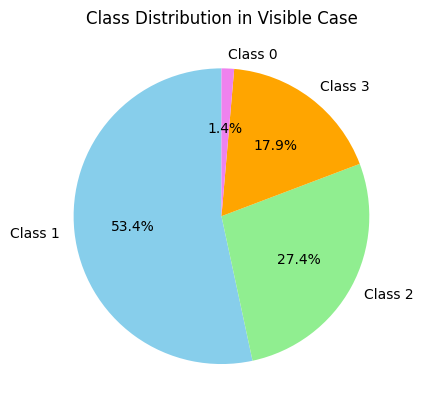

In [ ]:
# Pie Chart
colors = ['skyblue', 'lightgreen', 'orange', 'violet']

plt.pie(data.loc[data['case'] == 'visible', ['class1', 'class2', 'class3', 'class0']].values[0],
        labels=['Class 1', 'Class 2', 'Class 3', 'Class 0'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
plt.title('Class Distribution in Visible Case')
plt.show()

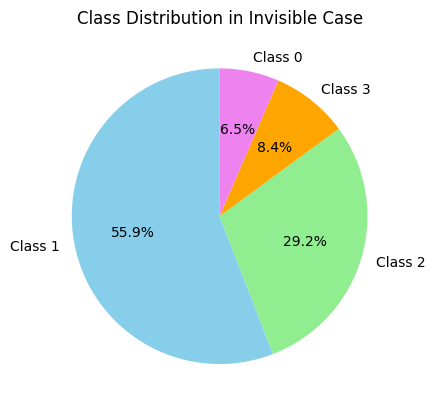

In [ ]:
# Pie Chart
plt.pie(data.loc[data['case'] == 'invisible', ['class1', 'class2', 'class3', 'class0']].values[0],
        labels=['Class 1', 'Class 2', 'Class 3', 'Class 0'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
plt.title('Class Distribution in Invisible Case')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample data
data_vis = {
    'labels': ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
    'values': [1783, 69768, 35758, 24439, 6105]
}
data_invis = {
    'labels': ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
    'values': [9276, 63548, 37601, 9740, 19244]
}

# Define a custom autopct function
# def autopct_func(pct):
#     if pct > 5:
#         return '{:.1f}%'.format(pct)
#     else:
#         return ''

# plt.figure(figsize=(8, 6))

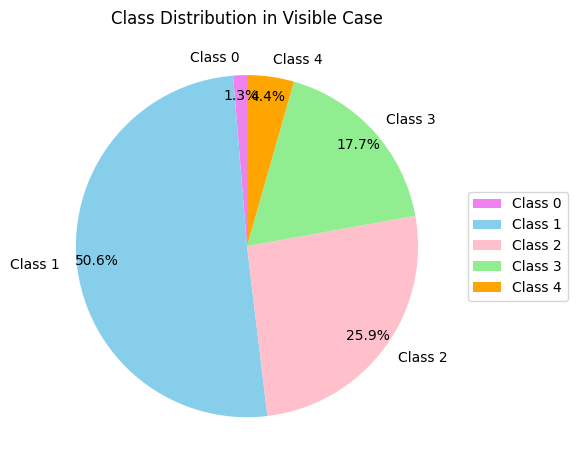

In [ ]:
colors = ['violet', 'skyblue', 'pink', 'lightgreen', 'orange']

wedges, labels, _ = plt.pie(data_vis['values'], labels=data_vis['labels'], autopct='%1.1f%%',
                            startangle=90, colors=colors, pctdistance=0.88)  # Adjust horizontal alignment
plt.title('Class Distribution in Visible Case')

# Adding the legend outside the pie chart
plt.legend(wedges, data_vis['labels'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

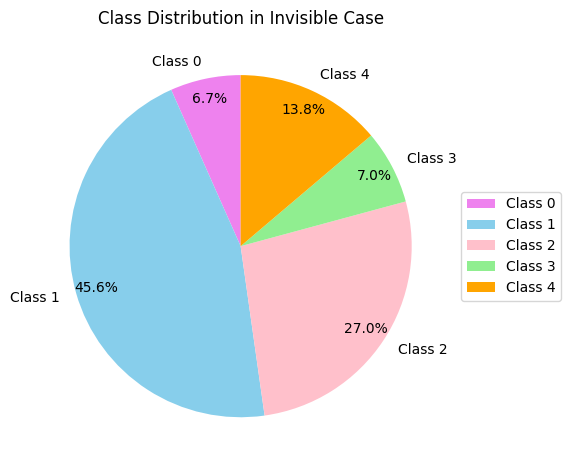

In [ ]:
wedges, labels, _ = plt.pie(data_invis['values'], labels=data_invis['labels'], autopct='%1.1f%%',
                            startangle=90, colors=colors, pctdistance=0.88)  # Adjust horizontal alignment
plt.title('Class Distribution in Invisible Case')

# Adding the legend outside the pie chart
plt.legend(wedges, data_invis['labels'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

In [ ]:
# # Pie Chart
# labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 0']
# colors = ['skyblue', 'pink', 'lightgreen', 'orange', 'violet']
# # plt.figure(figsize=(8, 6))
# wedges, labels, _ = plt.pie(data_org.loc[data_org['case'] == 'visible', ['class1', 'class2', 'class3', 'class4', 'class0']].values[0],
#         labels=labels,
#         autopct='%1.1f%%',
#         colors=colors,
#         startangle=90,
#         pctdistance=0.88)
# plt.title('Class Distribution in Visible Case')
# # plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# plt.tight_layout()
# plt.show()

In [ ]:
# # Pie Chart
# colors = ['skyblue', 'pink', 'lightgreen', 'orange', 'violet']

# plt.pie(data_org.loc[data['case'] == 'invisible', ['class1', 'class2', 'class3', 'class4', 'class0']].values[0],
#         labels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 0'],
#         autopct='%1.1f%%',
#         colors=colors,
#         startangle=90)
# plt.title('Class Distribution in Invisible Case')
# plt.show()

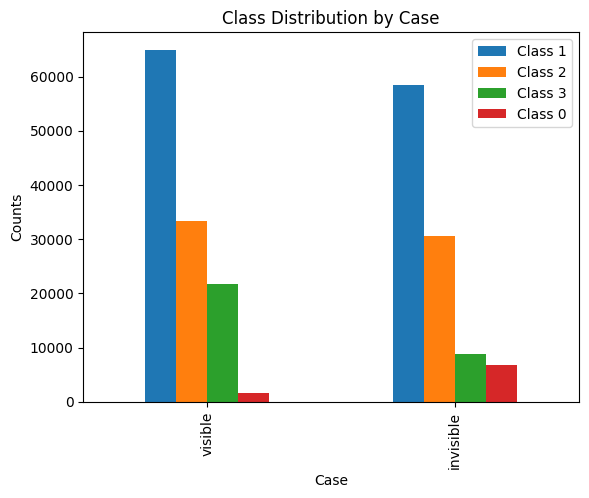

In [ ]:
# Grouped Bar Plot
data[['class1', 'class2', 'class3', 'class0']].plot(kind='bar')
plt.xticks(data.index, data['case'])
plt.xlabel('Case')
plt.ylabel('Counts')
plt.title('Class Distribution by Case')
plt.legend(['Class 1', 'Class 2', 'Class 3', 'Class 0'])
plt.show()

# Matching percentage (all videos)

Matching percentage between human and models (l2cs, baseline) without class 4

>>> parameter setting:
df_vis_clean_event => event level
df_vis_clean => frame level

Percentage (frame level)

In [ ]:
# visible case for line plot of percentage
match_l2cs_vis = []
match_base = []
for f in df_vis_clean_event_no4_frame['file'].unique():
    df_vis_clean_event_no4_frame_single = df_vis_clean_event_no4_frame[df_vis_clean_event_no4_frame['file'] == f]
    match_base.append((df_vis_clean_event_no4_frame_single["class"] == df_vis_clean_event_no4_frame_single["base_class"]).sum() / len(df_vis_clean_event_no4_frame_single["class"]))
    match_l2cs_vis.append((df_vis_clean_event_no4_frame_single["class"] == df_vis_clean_event_no4_frame_single["m2prop_class"]).sum() / len(df_vis_clean_event_no4_frame_single["class"]))

In [ ]:
df_percentage_vis_frame = pd.DataFrame()
df_percentage_vis_frame['file'] = df_vis_clean_event_no4['file'].unique().tolist()
df_percentage_vis_frame['case'] = ['visible'] * len(df_percentage_vis_frame['file'])
df_percentage_vis_frame['Gaze_BB'] = match_l2cs_vis
df_percentage_vis_frame['Baseline'] = match_base

df_percentage_vis_frame.to_csv(root + 'results_analysis/frame_level/percentage_vis_raw_frame.csv')
df_melt_vis_frame = df_percentage_vis_frame.melt(id_vars=["file"], value_vars=["Gaze_BB", "Baseline"],
                                 var_name="method", value_name="Percentage")

In [ ]:
print(min(df_percentage_vis_frame['Gaze_BB']))
print(max(df_percentage_vis_frame['Gaze_BB']))
print(df_percentage_vis_frame['Gaze_BB'].mean())
print(df_percentage_vis_frame['Gaze_BB'].std())
print()
print(min(df_percentage_vis_frame['Baseline']))
print(max(df_percentage_vis_frame['Baseline']))
print(df_percentage_vis_frame['Baseline'].mean())
print(df_percentage_vis_frame['Baseline'].std())

0.18254437869822485
0.9705583756345177
0.5239936157396073
0.2058403494115398

0.022482435597189696
0.9003880983182406
0.5408195175383057
0.23710302910184858


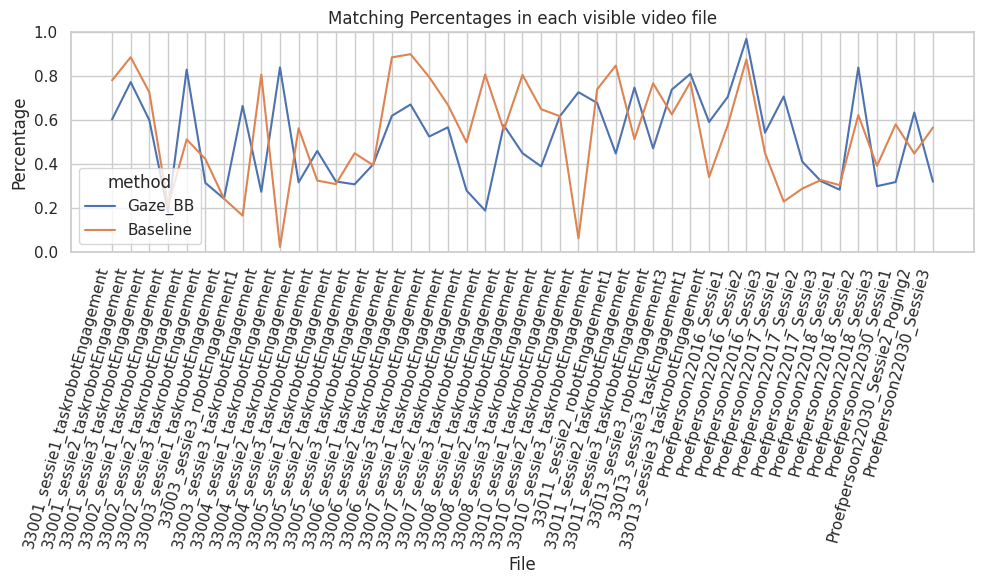

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="method", data=df_melt_vis_frame)
plt.xlabel("File")
plt.ylabel("Percentage")
plt.title("Matching Percentages in each visible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
# invisible case for line plot of percentage
match_l2cs_invis = []
match_m2prop_invis = []
for f in df_invis_clean_event_no4_frame['file'].unique():
    df_invis_clean_event_no4_single = df_invis_clean_event_no4_frame[df_invis_clean_event_no4_frame['file'] == f]
    match_m2prop_invis.append((df_invis_clean_event_no4_single["class"] == df_invis_clean_event_no4_single["m2prop_class"]).sum() / len(df_invis_clean_event_no4_single["class"]))
    match_l2cs_invis.append((df_invis_clean_event_no4_single["class"] == df_invis_clean_event_no4_single["l2cs_pred_class"]).sum() / len(df_invis_clean_event_no4_single["class"]))

In [ ]:
df_percentage_invis_frame = pd.DataFrame()
df_percentage_invis_frame['file'] = df_invis_clean_event_no4['file'].unique().tolist()
df_percentage_invis_frame['case'] = ['invisible'] * len(df_percentage_invis_frame['file'])
df_percentage_invis_frame['L2CS'] = match_l2cs_invis
df_percentage_invis_frame['Gaze_BB'] = match_m2prop_invis

df_percentage_invis_frame.to_csv(root + 'results_analysis/frame_level/percentage_invis_raw_frame.csv')
df_melt_invis_frame = df_percentage_invis_frame.melt(id_vars=["file"], value_vars=["L2CS", "Gaze_BB"],
                                 var_name="method", value_name="Percentage")

In [ ]:
print(min(df_percentage_invis_frame['Gaze_BB']))
print(max(df_percentage_invis_frame['Gaze_BB']))
print(df_percentage_invis_frame['Gaze_BB'].mean())
print(df_percentage_invis_frame['Gaze_BB'].std())

0.040498442367601244
1.0
0.6245087872073364
0.25278065090156354


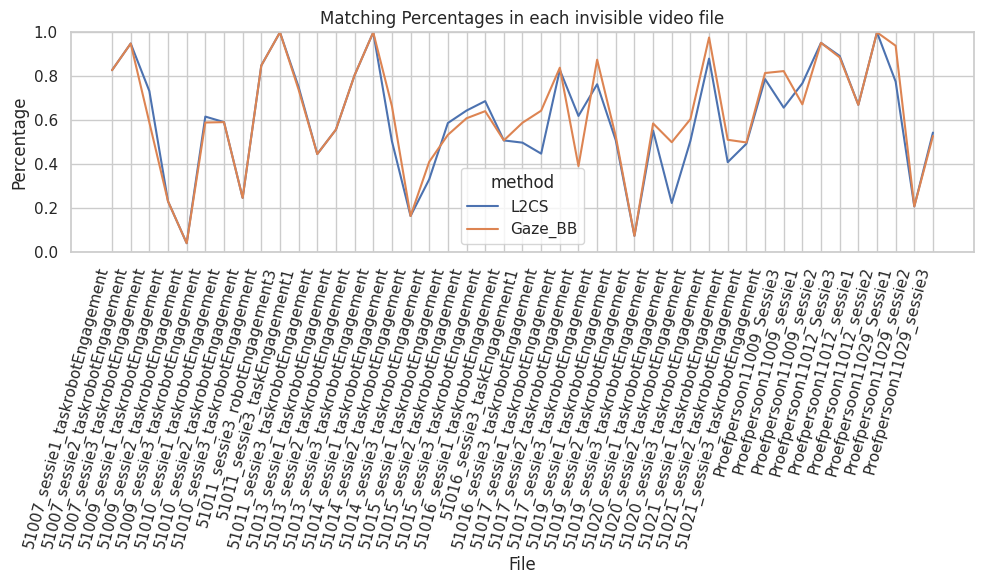

In [ ]:
# line plot for invisible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="method", data=df_melt_invis_frame)
plt.xlabel("File")
plt.ylabel("Percentage")
plt.title("Matching Percentages in each invisible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

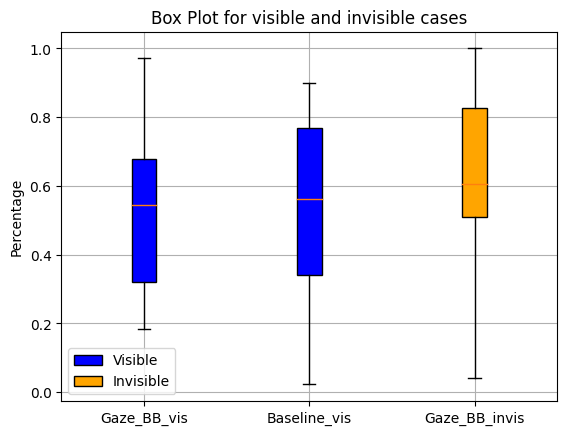

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()

bp1 = ax.boxplot([df_percentage_vis_frame['Gaze_BB'], df_percentage_vis_frame['Baseline']], vert=True, positions=[1, 2], labels=['Gaze_BB_vis', 'Baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot(df_percentage_invis_frame['Gaze_BB'], vert=True, positions=[3], labels=['Gaze_BB_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Visible', 'Invisible'])
plt.grid()
plt.ylabel('Percentage')
plt.title('Box Plot for visible and invisible cases')
plt.show()

Percentage (event level)

In [ ]:
# visible case for line plot of percentage
match_l2cs_vis = []
match_base = []
for f in df_vis_clean_event_no4['file'].unique():
    df_vis_clean_event_no4_single = df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]
    match_base.append((df_vis_clean_event_no4_single["class"] == df_vis_clean_event_no4_single["base_class"]).sum() / len(df_vis_clean_event_no4_single["class"]))
    match_l2cs_vis.append((df_vis_clean_event_no4_single["class"] == df_vis_clean_event_no4_single["m2prop_class"]).sum() / len(df_vis_clean_event_no4_single["class"]))

In [ ]:
df_percentage_vis = pd.DataFrame()
df_percentage_vis['file'] = df_vis_clean_event_no4['file'].unique().tolist()
df_percentage_vis['case'] = ['visible'] * len(df_percentage_vis['file'])
df_percentage_vis['l2cs_m2p'] = match_l2cs_vis
df_percentage_vis['baseline'] = match_base

df_percentage_vis.to_csv(root + 'results_analysis/event_level/percentage_vis_rawfloat.csv')
df_melt_vis = df_percentage_vis.melt(id_vars=["file"], value_vars=["l2cs_m2p", "baseline"],
                                 var_name="method", value_name="Percentage")

In [ ]:
# used x y axis for the plot below
print(df_percentage_vis['file'].tolist()) # x-axis
print(df_percentage_vis['l2cs_m2p'].tolist()) # y-axis for l2cs
print(df_percentage_vis['baseline'].tolist()) # y-axis for baseline

['33001_sessie1_taskrobotEngagement', '33001_sessie2_taskrobotEngagement', '33001_sessie3_taskrobotEngagement', '33002_sessie1_taskrobotEngagement', '33002_sessie2_taskrobotEngagement', '33002_sessie3_taskrobotEngagement', '33003_sessie1_taskrobotEngagement', '33003_sessie3_robotEngagement1', '33003_sessie3_taskrobotEngagement', '33004_sessie1_taskrobotEngagement', '33004_sessie2_taskrobotEngagement', '33004_sessie3_taskrobotEngagement', '33005_sessie1_taskrobotEngagement', '33005_sessie2_taskrobotEngagement', '33005_sessie3_taskrobotEngagement', '33006_sessie1_taskrobotEngagement', '33006_sessie2_taskrobotEngagement', '33006_sessie3_taskrobotEngagement', '33007_sessie1_taskrobotEngagement', '33007_sessie2_taskrobotEngagement', '33007_sessie3_taskrobotEngagement', '33008_sessie1_taskrobotEngagement', '33008_sessie2_taskrobotEngagement', '33008_sessie3_taskrobotEngagement', '33010_sessie1_taskrobotEngagement', '33010_sessie2_taskrobotEngagement', '33010_sessie3_taskrobotEngagement', '33

In [ ]:
print(min(df_percentage_vis['l2cs_m2p']))
print(max(df_percentage_vis['l2cs_m2p']))
print(df_percentage_vis['l2cs_m2p'].mean())
print(df_percentage_vis['l2cs_m2p'].std())
print()
print(min(df_percentage_vis['baseline']))
print(max(df_percentage_vis['baseline']))
print(df_percentage_vis['baseline'].mean())
print(df_percentage_vis['baseline'].std())

0.20833333333333334
0.8461538461538461
0.46894911852004867
0.14577607725274946

0.125
0.8148148148148148
0.4582406498454989
0.1552354673780997


In [ ]:
df_melt_vis

file    method  Percentage
0   33001_sessie1_taskrobotEngagement  l2cs_m2p    0.580645
1   33001_sessie2_taskrobotEngagement  l2cs_m2p    0.518519
2   33001_sessie3_taskrobotEngagement  l2cs_m2p    0.423077
3   33002_sessie1_taskrobotEngagement  l2cs_m2p    0.518519
4   33002_sessie2_taskrobotEngagement  l2cs_m2p    0.451613
..                                ...       ...         ...
85          Proefpersoon22018_Sessie2  baseline    0.416667
86          Proefpersoon22018_Sessie3  baseline    0.357143
87          Proefpersoon22030_Sessie1  baseline    0.428571
88  Proefpersoon22030_Sessie2_Poging2  baseline    0.380952
89          Proefpersoon22030_Sessie3  baseline    0.368421

[90 rows x 3 columns]

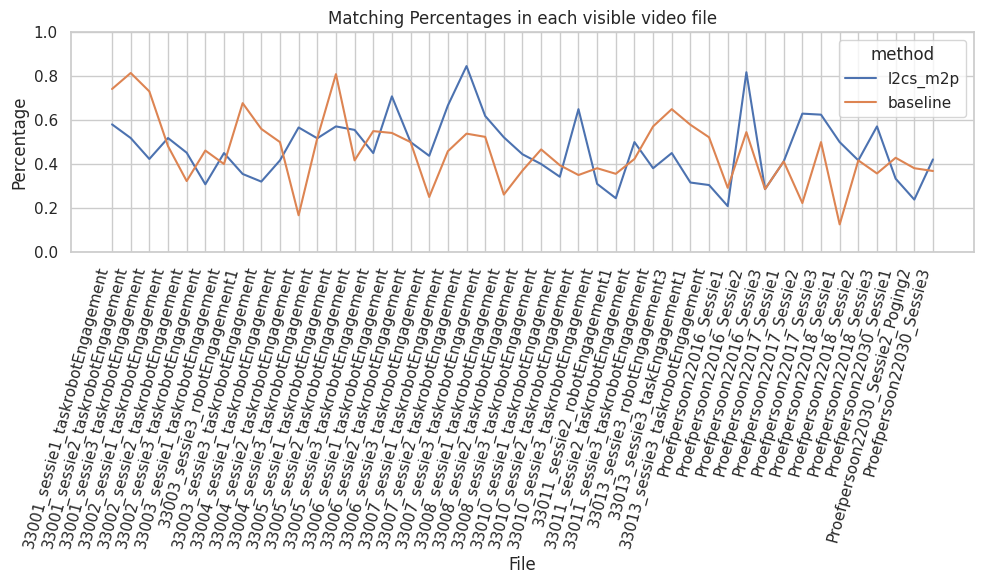

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="method", data=df_melt_vis)
plt.xlabel("File")
plt.ylabel("Percentage")
plt.title("Matching Percentages in each visible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
# invisible case for line plot of percentage
match_l2cs_invis = []
match_m2prop_invis = []
for f in df_invis_clean_event_no4['file'].unique():
    df_invis_clean_event_no4_single = df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]
    match_m2prop_invis.append((df_invis_clean_event_no4_single["class"] == df_invis_clean_event_no4_single["m2prop_class"]).sum() / len(df_invis_clean_event_no4_single["class"]))
    match_l2cs_invis.append((df_invis_clean_event_no4_single["class"] == df_invis_clean_event_no4_single["l2cs_pred_class"]).sum() / len(df_invis_clean_event_no4_single["class"]))

In [ ]:
df_percentage_invis = pd.DataFrame()
df_percentage_invis['file'] = df_invis_clean_event_no4['file'].unique().tolist()
df_percentage_invis['case'] = ['invisible'] * len(df_percentage_invis['file'])
df_percentage_invis['l2cs_org'] = match_l2cs_invis
df_percentage_invis['l2cs_m2prop'] = match_m2prop_invis

df_percentage_invis.to_csv(root + 'results_analysis/event_level/percentage_invis_rawfloat.csv')
df_melt_invis = df_percentage_invis.melt(id_vars=["file"], value_vars=["l2cs_org", "l2cs_m2prop"],
                                 var_name="method", value_name="Percentage")

In [ ]:
# used x y axis for the plot below
print(df_percentage_invis['file'].tolist()) # x-axis
print(df_percentage_invis['l2cs_m2prop'].tolist()) # y-axis for l2cs

['51007_sessie1_taskrobotEngagement', '51007_sessie2_taskrobotEngagement', '51007_sessie3_taskrobotEngagement', '51009_sessie1_taskrobotEngagement', '51009_sessie2_taskrobotEngagement', '51009_sessie3_taskrobotEngagement', '51010_sessie1_taskrobotEngagement', '51010_sessie2_taskrobotEngagement', '51010_sessie3_taskrobotEngagement', '51011_sessie3_robotEngagement3', '51011_sessie3_taskEngagement1', '51011_sessie3_taskrobotEngagement', '51013_sessie1_taskrobotEngagement', '51013_sessie2_taskrobotEngagement', '51013_sessie3_taskrobotEngagement', '51014_sessie1_taskrobotEngagement', '51014_sessie2_taskrobotEngagement', '51014_sessie3_taskrobotEngagement', '51015_sessie1_taskrobotEngagement', '51015_sessie2_taskrobotEngagement', '51015_sessie3_taskrobotEngagement', '51016_sessie1_taskrobotEngagement', '51016_sessie3_taskEngagement1', '51016_sessie3_taskrobotEngagement', '51017_sessie1_taskrobotEngagement', '51017_sessie2_taskrobotEngagement', '51017_sessie3_taskrobotEngagement', '51019_sess

In [ ]:
print(min(df_percentage_invis['l2cs_m2prop']))
print(max(df_percentage_invis['l2cs_m2prop']))
print(df_percentage_invis['l2cs_m2prop'].mean())
print(df_percentage_invis['l2cs_m2prop'].std())

0.125
1.0
0.604158460284812
0.21659358340698417


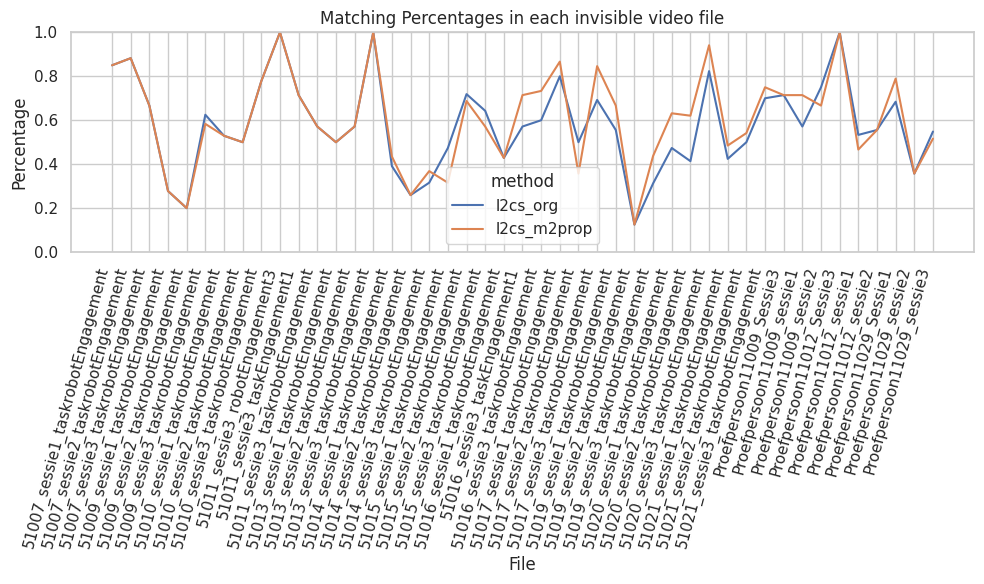

In [ ]:
# line plot for invisible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="method", data=df_melt_invis)
plt.xlabel("File")
plt.ylabel("Percentage")
plt.title("Matching Percentages in each invisible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
# used x y axis for the plot below
print(df_percentage_vis['l2cs_m2p'].tolist()) # x-axis
print(df_percentage_vis['baseline'].tolist()) # x-axis
print(df_percentage_invis['l2cs_m2prop'].tolist()) # x-axis

[0.5806451612903226, 0.5185185185185185, 0.4230769230769231, 0.5185185185185185, 0.45161290322580644, 0.3076923076923077, 0.45, 0.3548387096774194, 0.32, 0.4166666666666667, 0.5666666666666667, 0.5172413793103449, 0.5714285714285714, 0.5555555555555556, 0.45, 0.7083333333333334, 0.5, 0.4375, 0.6666666666666666, 0.8461538461538461, 0.6190476190476191, 0.5217391304347826, 0.4444444444444444, 0.4, 0.34210526315789475, 0.65, 0.30952380952380953, 0.24444444444444444, 0.5, 0.38095238095238093, 0.45, 0.3157894736842105, 0.30434782608695654, 0.20833333333333334, 0.8181818181818182, 0.2857142857142857, 0.4117647058823529, 0.6296296296296297, 0.625, 0.5, 0.4166666666666667, 0.5714285714285714, 0.3333333333333333, 0.23809523809523808, 0.42105263157894735]
[0.7419354838709677, 0.8148148148148148, 0.7307692307692307, 0.48148148148148145, 0.3225806451612903, 0.46153846153846156, 0.4, 0.6774193548387096, 0.56, 0.5, 0.16666666666666666, 0.5172413793103449, 0.8095238095238095, 0.4166666666666667, 0.55,

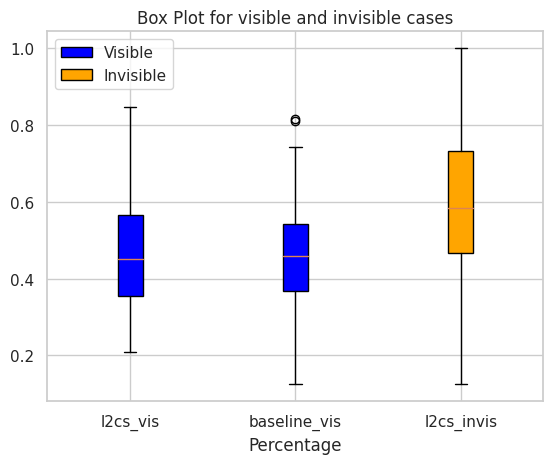

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()

bp1 = ax.boxplot([df_percentage_vis['l2cs_m2p'], df_percentage_vis['baseline']], vert=True, positions=[1, 2], labels=['l2cs_vis', 'baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot(df_percentage_invis['l2cs_m2prop'], vert=True, positions=[3], labels=['l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Visible', 'Invisible'])

plt.xlabel('Percentage')
plt.title('Box Plot for visible and invisible cases')
plt.show()

# Cohen's kappa score (all videos)

FRAME LEVEL - frame level

In [ ]:
dfkappa_vis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manbase', 'ckappa_manl2cs_li', 'ckappa_manbase_li', 'ckappa_manl2cs_qua', 'ckappa_manbase_qua'])
for f in df_vis_clean_event_no4_frame['file'].unique():
    fcase = list(df_vis_clean_event_no4_frame[df_vis_clean_event_no4_frame['file'] == f]['case'])[0]
    manual = list(df_vis_clean_event_no4_frame[df_vis_clean_event_no4_frame['file'] == f]['class'])
    l2cs = list(df_vis_clean_event_no4_frame[df_vis_clean_event_no4_frame['file'] == f]['m2prop_class'])
    base = list(df_vis_clean_event_no4_frame[df_vis_clean_event_no4_frame['file'] == f]['base_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_base_li = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    cohenk_base_qua = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    dfkappa_vis_no4.loc[len(dfkappa_vis_no4)] = [f, fcase, cohenk_l2cs, cohenk_base, cohenk_l2cs_li, cohenk_base_li, cohenk_l2cs_qua, cohenk_base_qua]


print(dfkappa_vis_no4['ckappa_manl2cs'].mean())
print(dfkappa_vis_no4['ckappa_manl2cs'].min())
print(dfkappa_vis_no4['ckappa_manl2cs'].max())
print()
print(dfkappa_vis_no4['ckappa_manbase'].mean())
print(dfkappa_vis_no4['ckappa_manbase'].min())
print(dfkappa_vis_no4['ckappa_manbase'].max())
dfkappa_vis_no4.to_csv(root + 'results_analysis/frame_level/ckappa_vis_mlb_no4_frame.csv')


0.22610478004091472
-0.22344117344207737
0.8520810408440675

0.24661263433322758
-0.3455624269383337
0.7935702084642284


In [ ]:
dfkappa_invis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua'])
for f in df_invis_clean_event_no4_frame['file'].unique():
    fcase = list(df_invis_clean_event_no4_frame[df_invis_clean_event_no4_frame['file'] == f]['case'])[0]
    manual = list(df_invis_clean_event_no4_frame[df_invis_clean_event_no4_frame['file'] == f]['class'])
    l2cs = list(df_invis_clean_event_no4_frame[df_invis_clean_event_no4_frame['file'] == f]['m2prop_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    dfkappa_invis_no4.loc[len(dfkappa_invis_no4)] = [f, fcase, cohenk_l2cs, cohenk_l2cs_li, cohenk_l2cs_qua]

print(dfkappa_invis_no4['ckappa_manl2cs'].mean())
print(dfkappa_invis_no4['ckappa_manl2cs'].min())
print(dfkappa_invis_no4['ckappa_manl2cs'].max())
print()
# print(dfkappa_invis_no4)
dfkappa_invis_no4.to_csv(root + 'results_analysis/frame_level/ckappa_invis_ml_no4_frame.csv')


0.36487256673120627
-0.5188622575493156
1.0



In [ ]:
df_kappa_vis_frame_melt = dfkappa_vis_no4.melt(id_vars=["file"], value_vars=["ckappa_manl2cs", "ckappa_manbase"],
                                 var_name="measure type", value_name="Score")
df_kappa_invis_frame_melt = dfkappa_invis_no4.melt(id_vars=["file"], value_vars=["ckappa_manl2cs"],
                                 var_name="measure type", value_name="Score")

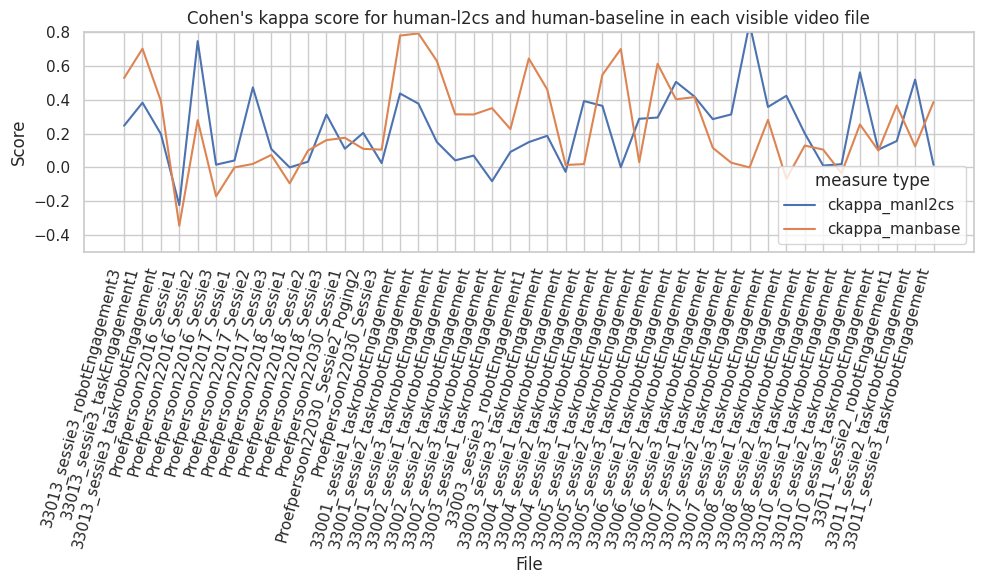

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_vis_frame_melt)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Cohen's kappa score for human-l2cs and human-baseline in each visible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 0.8)  # Set the y-axis limits
plt.tight_layout()
plt.show()

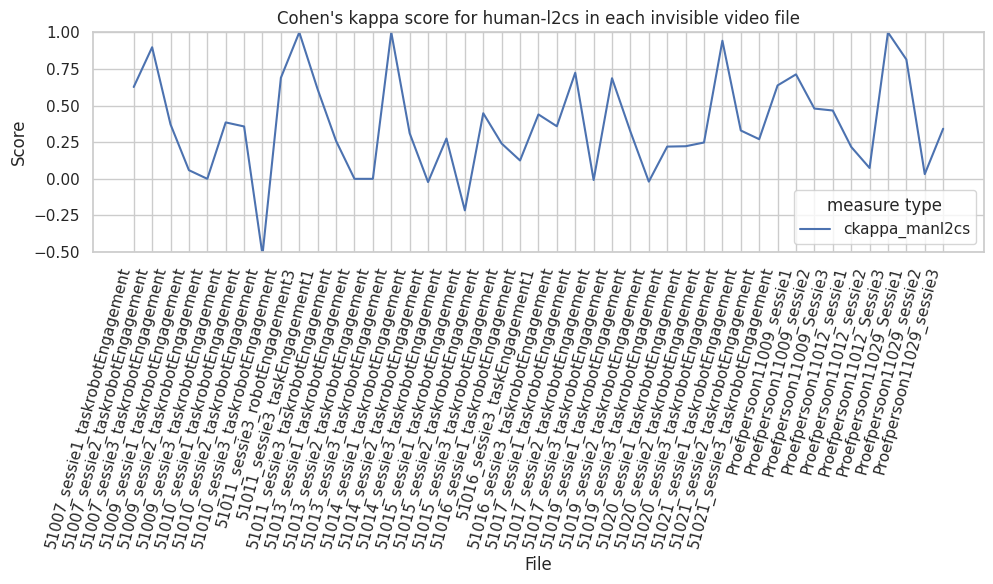

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_invis_frame_melt)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Cohen's kappa score for human-l2cs in each invisible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

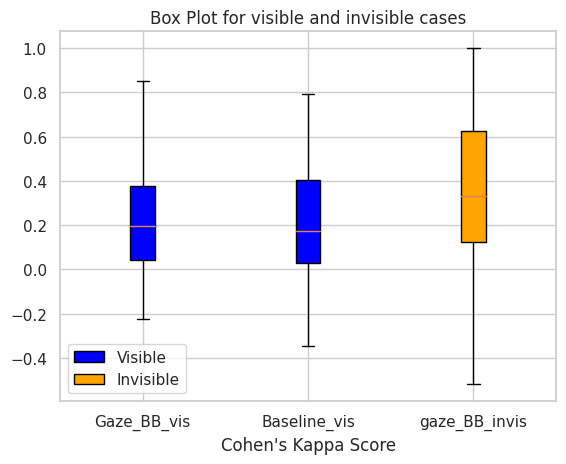

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()

bp1 = ax.boxplot([dfkappa_vis_no4['ckappa_manl2cs'], dfkappa_vis_no4['ckappa_manbase']], vert=True, positions=[1, 2], labels=['Gaze_BB_vis', 'Baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot(dfkappa_invis_no4['ckappa_manl2cs'], vert=True, positions=[3], labels=['gaze_BB_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Visible', 'Invisible'])

plt.xlabel("Cohen's Kappa Score")
plt.title('Box Plot for visible and invisible cases')
plt.show()

EVENT LEVEL - event level

Cohen's kappa score between human and l2cs


>>> parameter setting:
df_vis_clean_event (df_vis_clean_event_no4) => event level
df_vis_clean (df_vis_clean_no4) => frame level

for visible case (with class 4)

In [ ]:
dfkappa_vis = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manbase', 'ckappa_manl2cs_li', 'ckappa_manbase_li', 'ckappa_manl2cs_qua', 'ckappa_manbase_qua',])
for f in df_vis_clean_event['file'].unique():
    fcase = list(df_vis_clean_event[df_vis_clean_event['file'] == f]['case'])[0]
    manual = list(df_vis_clean_event[df_vis_clean_event['file'] == f]['class'])
    l2cs = list(df_vis_clean_event[df_vis_clean_event['file'] == f]['m2prop_class'])
    base = list(df_vis_clean_event[df_vis_clean_event['file'] == f]['base_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN])
    cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='linear')
    cohenk_base_li = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='quadratic')
    cohenk_base_qua = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='quadratic')
    dfkappa_vis.loc[len(dfkappa_vis)] = [f, fcase, cohenk_l2cs, cohenk_base, cohenk_l2cs_li, cohenk_base_li, cohenk_l2cs_qua, cohenk_base_qua]

print(dfkappa_vis['ckappa_manl2cs'].mean())
print(dfkappa_vis['ckappa_manl2cs'].min())
print(dfkappa_vis['ckappa_manl2cs'].max())
print()
print(dfkappa_vis['ckappa_manbase'].mean())
print(dfkappa_vis['ckappa_manbase'].min())
print(dfkappa_vis['ckappa_manbase'].max())
# print(dfkappa_vis)
dfkappa_vis.to_csv(root + 'results_analysis/event_level/ckappa_vis_mlb.csv')

0.20762698666668927
-0.13361462728551343
0.723404255319149

0.1829827831377568
-0.2019386106623584
0.6500867553499132


for visible case (without class 4)

In [ ]:
dfkappa_vis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manbase', 'ckappa_manl2cs_li', 'ckappa_manbase_li', 'ckappa_manl2cs_qua', 'ckappa_manbase_qua'])
for f in df_vis_clean_event_no4['file'].unique():
    fcase = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['case'])[0]
    manual = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['class'])
    l2cs = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['m2prop_class'])
    base = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['base_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_base_li = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    cohenk_base_qua = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    dfkappa_vis_no4.loc[len(dfkappa_vis_no4)] = [f, fcase, cohenk_l2cs, cohenk_base, cohenk_l2cs_li, cohenk_base_li, cohenk_l2cs_qua, cohenk_base_qua]


print(dfkappa_vis_no4['ckappa_manl2cs'].mean())
print(dfkappa_vis_no4['ckappa_manl2cs'].min())
print(dfkappa_vis_no4['ckappa_manl2cs'].max())
print()
print(dfkappa_vis_no4['ckappa_manbase'].mean())
print(dfkappa_vis_no4['ckappa_manbase'].min())
print(dfkappa_vis_no4['ckappa_manbase'].max())
dfkappa_vis_no4.to_csv(root + 'results_analysis/event_level/ckappa_vis_mlb_no4.csv')


0.21611662825262945
-0.1875
0.7302452316076294

0.18580879297276395
-0.2592592592592593
0.6715328467153284


for invisible case (with class 4)

In [ ]:
dfkappa_invis = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua'])
for f in df_invis_clean_event['file'].unique():
    fcase = list(df_invis_clean_event[df_invis_clean_event['file'] == f]['case'])[0]
    manual = list(df_invis_clean_event[df_invis_clean_event['file'] == f]['class'])
    l2cs = list(df_invis_clean_event[df_invis_clean_event['file'] == f]['m2prop_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE, UNKNOWN], weights='quadratic')
    dfkappa_invis.loc[len(dfkappa_invis)] = [f, fcase, cohenk_l2cs, cohenk_l2cs_li, cohenk_l2cs_qua]

print(dfkappa_invis['ckappa_manl2cs'].mean())
print(dfkappa_invis['ckappa_manl2cs'].min())
print(dfkappa_invis['ckappa_manl2cs'].max())
print()
# print(dfkappa_invis)
dfkappa_invis.to_csv(root + 'results_analysis/event_level/ckappa_invis_ml.csv')

0.31591213751820224
-0.11055276381909551
1.0



for invisible case (without class 4)

In [ ]:
dfkappa_invis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua'])
for f in df_invis_clean_event_no4['file'].unique():
    fcase = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['case'])[0]
    manual = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['class'])
    l2cs = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['m2prop_class'])

    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_l2cs_li = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
    cohenk_l2cs_qua = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
    dfkappa_invis_no4.loc[len(dfkappa_invis_no4)] = [f, fcase, cohenk_l2cs, cohenk_l2cs_li, cohenk_l2cs_qua]

print(dfkappa_invis_no4['ckappa_manl2cs'].mean())
print(dfkappa_invis_no4['ckappa_manl2cs'].min())
print(dfkappa_invis_no4['ckappa_manl2cs'].max())
print()
# print(dfkappa_invis_no4)
dfkappa_invis_no4.to_csv(root + 'results_analysis/event_level/ckappa_invis_ml_no4.csv')


0.3926818491512301
-0.22277227722772275
1.0



In [ ]:
df_kappa_vis_melt = dfkappa_vis_no4.melt(id_vars=["file"], value_vars=["ckappa_manl2cs", "ckappa_manbase"],
                                 var_name="measure type", value_name="Score")
df_kappa_invis_melt = dfkappa_invis_no4.melt(id_vars=["file"], value_vars=["ckappa_manl2cs"],
                                 var_name="measure type", value_name="Score")

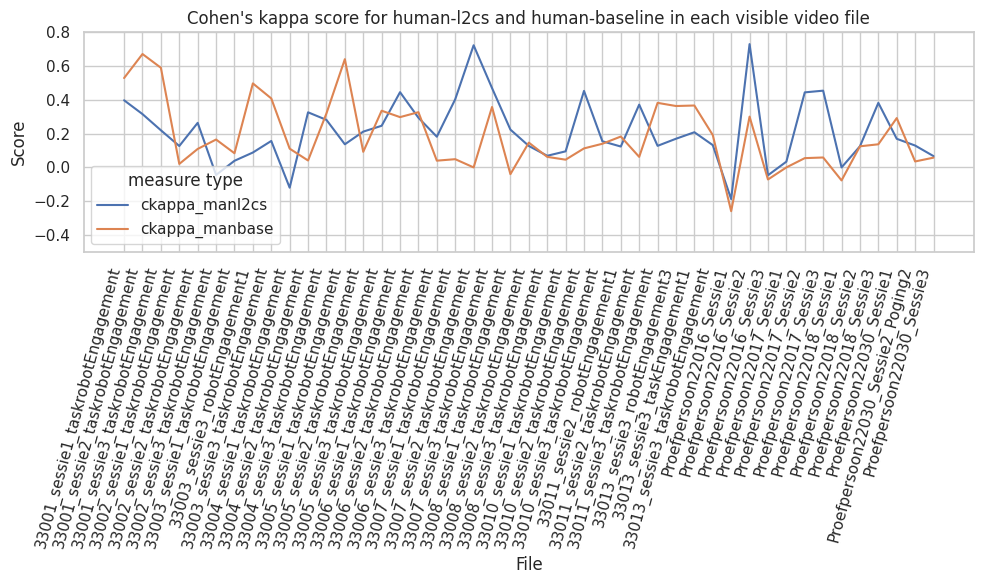

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_vis_melt)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Cohen's kappa score for human-l2cs and human-baseline in each visible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 0.8)  # Set the y-axis limits
plt.tight_layout()
plt.show()

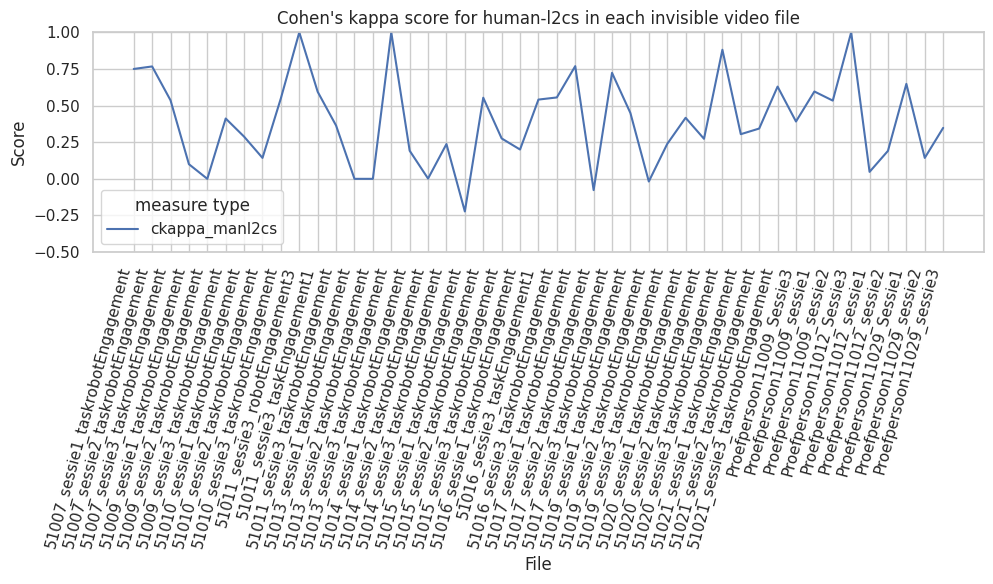

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_invis_melt)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Cohen's kappa score for human-l2cs in each invisible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

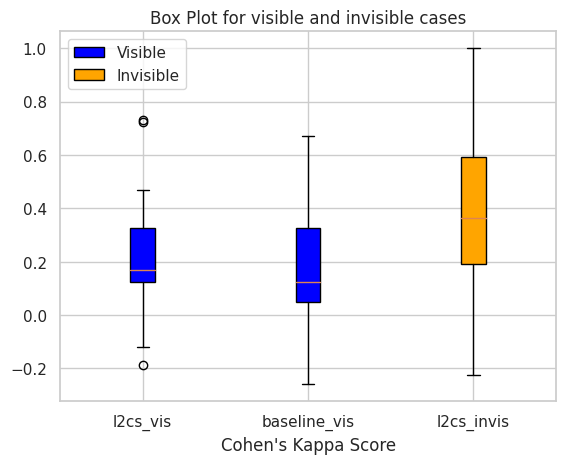

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()

bp1 = ax.boxplot([dfkappa_vis_no4['ckappa_manl2cs'], dfkappa_vis_no4['ckappa_manbase']], vert=True, positions=[1, 2], labels=['l2cs_vis', 'baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot(dfkappa_invis_no4['ckappa_manl2cs'], vert=True, positions=[3], labels=['l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Visible', 'Invisible'])

plt.xlabel("Cohen's Kappa Score")
plt.title('Box Plot for visible and invisible cases')
plt.show()

# Krippendorff's alpha score (all videos)

Krippendorff's alpha for manual-l2cs (invis), manual-l2cs (vis) and manual-baseline (vis)

In [ ]:
krippen_l2cs_vis = []
krippen_base = []
# manual >>>
# df_vis_clean_event['class']
# l2cs >>>
# df_vis_clean_event['m2prop_class']
# baseline >>>
# df_vis_clean_event['base_class']

# visible case
for f in df_vis_clean_event_no4['file'].unique():
    anns_manl2cs = []
    anns_manbase = []
    manual = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['class'])
    l2cs = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['m2prop_class'])
    base = list(df_vis_clean_event_no4[df_vis_clean_event_no4['file'] == f]['base_class'])

    anns_manl2cs.append(manual)
    anns_manl2cs.append(l2cs)
    anns_manbase.append(manual)
    anns_manbase.append(base)

    krippen_l2cs_vis.append(kd.alpha(anns_manl2cs, level_of_measurement='nominal'))
    krippen_base.append(kd.alpha(anns_manbase, level_of_measurement='nominal'))


In [ ]:
print(krippen_l2cs_vis)
print(np.array(krippen_l2cs_vis).mean())
print()
print(krippen_base)
print(np.array(krippen_base).mean())
print()

[0.3721298495645289, 0.26148128484204924, 0.1997907949790796, -0.04552352048558417, 0.2613960113960113, -0.08173076923076916, -0.12010443864229758, 0.07012195121951226, 0.08961748633879785, -0.27519379844961245, 0.3121076233183857, 0.24503311258278138, -0.010958904109588996, 0.1173271173271172, 0.14200000000000002, 0.44519392917369305, 0.2247191011235956, 0.11708860759493667, 0.3691275167785234, 0.7282608695652174, 0.46753246753246747, 0.15384615384615397, 0.05017921146953408, 0.0076045627376425395, 0.04287901990811627, 0.4529058116232465, 0.08444275389882083, -0.001986754966887272, 0.3227783452502553, 0.10118043844856661, 0.11180124223602506, 0.10093457943925233, -0.022727272727272707, -0.296081277213353, 0.7308488612836439, -0.18042226487524005, -0.134020618556701, 0.4507772020725389, 0.4444444444444444, -0.15384615384615374, 0.08522727272727271, 0.3671875, 0.125, -0.026604068857589924, 0.012135922330097082]
0.14928669340202796

[0.531219980787704, 0.6718797914750076, 0.5924657534246

In [ ]:
df_krip_vis = pd.DataFrame()
df_krip_vis['file'] = df_vis_clean_event_no4['file'].unique().tolist()
df_krip_vis['case'] = ['visible'] * len(df_krip_vis)
df_krip_vis['krip_manl2cs'] = krippen_l2cs_vis
df_krip_vis['krip_manbase'] = krippen_base

df_krip_vis.to_csv(root + 'results_analysis/event_level/krip_vis.csv')

In [ ]:
df_krip_melt_vis = df_krip_vis.melt(id_vars=["file"], value_vars=["krip_manl2cs", "krip_manbase"],
                                 var_name="method", value_name="Score")

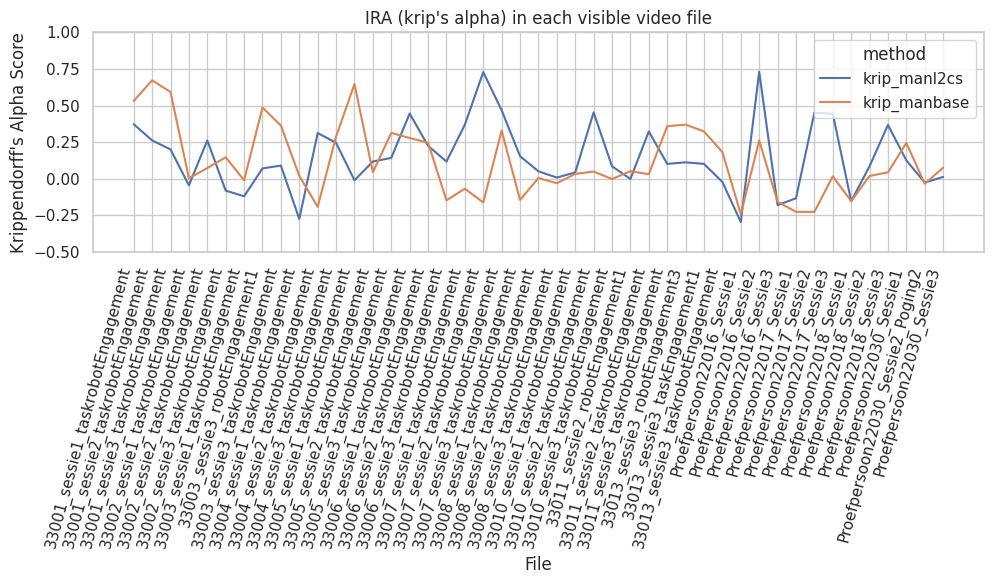

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_vis)
plt.xlabel("File")
plt.ylabel("Krippendorff's Alpha Score")
plt.title("IRA (krip's alpha) in each visible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
krippen_l2csm2p_invis = []
krippen_l2csorg_invis = []
# manual >>>
# df_vis_clean_event['class']
# l2cs >>>
# df_vis_clean_event['m2prop_class']
# baseline >>>
# df_vis_clean_event['base_class']

# invisible case
for f in df_invis_clean_event_no4['file'].unique():
    anns_manl2csm2p = []
    anns_manl2csorg = []
    manual = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['class'])
    l2csm2p = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['m2prop_class'])
    l2csorg = list(df_invis_clean_event_no4[df_invis_clean_event_no4['file'] == f]['l2cs_pred_class'])

    anns_manl2csm2p.append(manual)
    anns_manl2csm2p.append(l2csm2p)
    anns_manl2csorg.append(manual)
    anns_manl2csorg.append(l2csorg)

    krippen_l2csm2p_invis.append(kd.alpha(anns_manl2csm2p, level_of_measurement='nominal'))
    krippen_l2csorg_invis.append(kd.alpha(anns_manl2csorg, level_of_measurement='nominal'))


In [ ]:
df_krip_invis = pd.DataFrame()
df_krip_invis['file'] = df_invis_clean_event_no4['file'].unique().tolist()
df_krip_invis['case'] = ['invisible'] * len(df_krip_invis)
df_krip_invis['krip_manl2csm2p'] = krippen_l2csm2p_invis
df_krip_invis['krip_manl2csorg'] = krippen_l2csorg_invis

df_krip_vis.to_csv(root + 'results_analysis/event_level/krip_invis.csv')

In [ ]:
print(krippen_l2csm2p_invis)
print(np.array(krippen_l2csm2p_invis).mean())
print()

[0.755741127348643, 0.7708333333333333, 0.5420219244823385, -0.15776081424936406, -0.3384615384615386, 0.40506329113924056, 0.28455284552845517, 0.19512195121951215, 0.575, 1.0, 0.6058394160583942, 0.3769230769230769, -0.17647058823529416, -0.18181818181818188, 1.0, 0.20838971583220578, -0.0772357723577235, 0.14779270633397312, -0.255874673629243, 0.5572733661278988, 0.21739130434782605, 0.1428571428571428, 0.5537190082644629, 0.5687732342007434, 0.77431906614786, -0.23350253807106602, 0.7282608695652174, 0.4631578947368421, -0.10526315789473673, 0.15197568389057758, 0.4045977011494253, 0.1920103092783505, 0.8842105263157894, 0.29483088704530946, 0.34390862944162437, 0.632768361581921, 0.39534883720930225, 0.6038647342995169, 0.551219512195122, 1.0, -0.14285714285714302, 0.08496732026143805, 0.6476190476190475, 0.13523131672597877, 0.308390022675737]
0.3518828834791558



In [ ]:
df_krip_melt_invis = df_krip_invis.melt(id_vars=["file"], value_vars=["krip_manl2csm2p", "krip_manl2csorg"],
                                 var_name="method", value_name="Score")

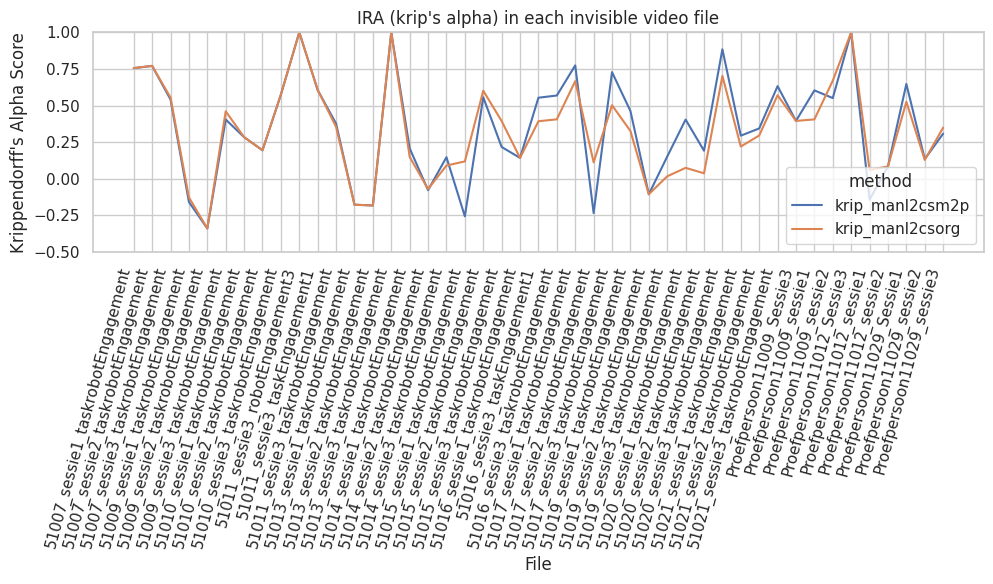

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_invis)
plt.xlabel("File")
plt.ylabel("Krippendorff's Alpha Score")
plt.title("IRA (krip's alpha) in each invisible video file")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

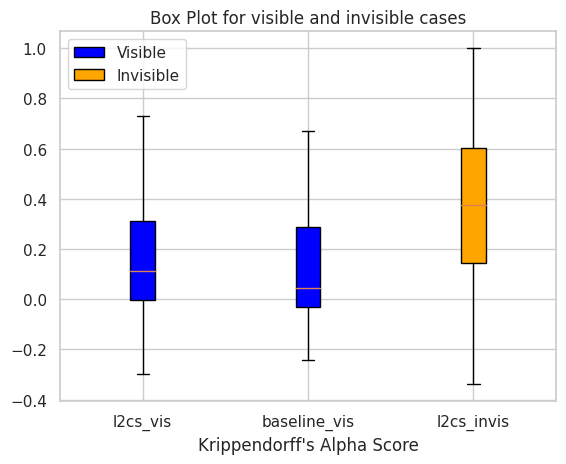

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()

bp1 = ax.boxplot([df_krip_vis['krip_manl2cs'], df_krip_vis['krip_manbase']], vert=True, positions=[1, 2], labels=['l2cs_vis', 'baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot(df_krip_invis['krip_manl2csm2p'], vert=True, positions=[3], labels=['l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Visible', 'Invisible'])

plt.xlabel("Krippendorff's Alpha Score")
plt.title('Box Plot for visible and invisible cases')
plt.show()

box plot for percentages, cohen's kappa, and krippendorff's alpha scores

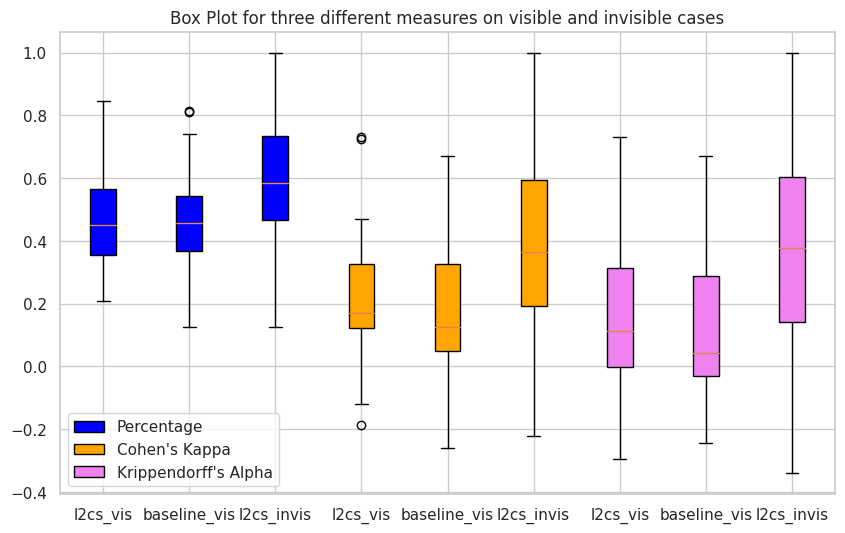

In [ ]:
# Draw the box plot for both DataFrames in one plot
fig, ax = plt.subplots(figsize=(10, 6))

bp1 = ax.boxplot([df_percentage_vis['l2cs_m2p'], df_percentage_vis['baseline'], df_percentage_invis['l2cs_m2prop']], vert=True, positions=[1, 2, 3], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([dfkappa_vis_no4['ckappa_manl2cs'], dfkappa_vis_no4['ckappa_manbase'], dfkappa_invis_no4['ckappa_manl2cs']], vert=True, positions=[4, 5, 6], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_krip_vis['krip_manl2cs'], df_krip_vis['krip_manbase'], df_krip_invis['krip_manl2csm2p']], vert=True, positions=[7, 8, 9], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["Percentage", "Cohen's Kappa", "Krippendorff's Alpha"])

plt.title('Box Plot for three different measures on visible and invisible cases')
plt.show()

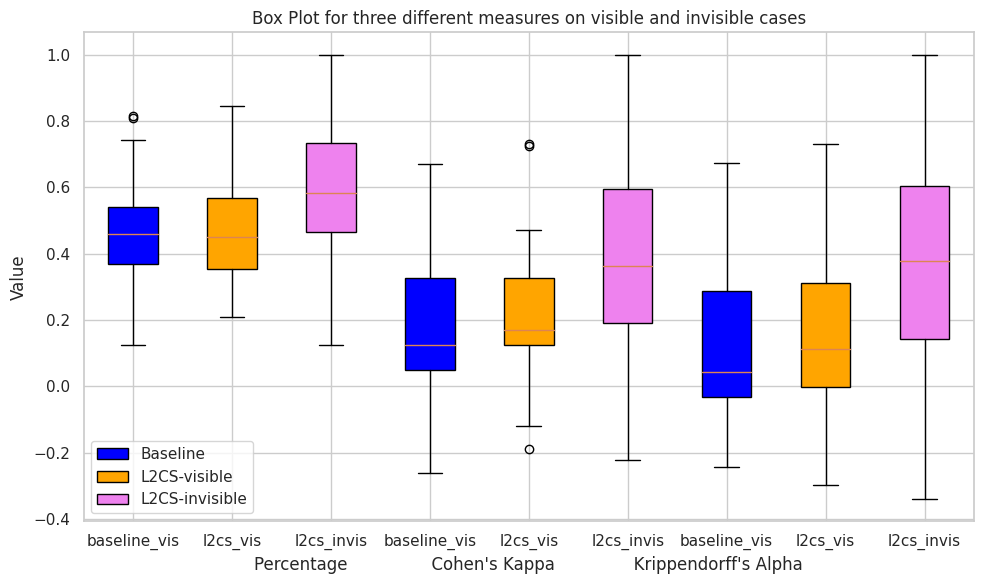

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
bp1 = ax.boxplot([df_percentage_vis['baseline'], dfkappa_vis_no4['ckappa_manbase'], df_krip_vis['krip_manbase']], vert=True, positions=[1, 4, 7], labels=['baseline_vis', 'baseline_vis', 'baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_vis['l2cs_m2p'], dfkappa_vis_no4['ckappa_manl2cs'], df_krip_vis['krip_manl2cs']], vert=True, positions=[2, 5, 8], labels=['l2cs_vis', 'l2cs_vis', 'l2cs_vis'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_percentage_invis['l2cs_m2prop'], dfkappa_invis_no4['ckappa_manl2cs'], df_krip_invis['krip_manl2csm2p']], vert=True, positions=[3, 6, 9], labels=['l2cs_invis', 'l2cs_invis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline', 'L2CS-visible', 'L2CS-invisible'])

plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for three different measures on visible and invisible cases')
plt.tight_layout()
plt.show()

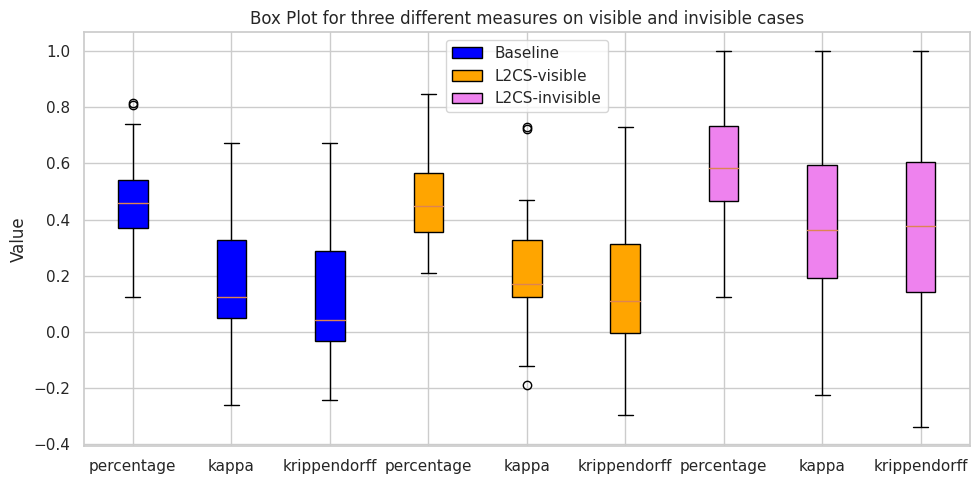

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure()
fig, ax = plt.subplots(figsize=(10, 5))
bp1 = ax.boxplot([df_percentage_vis['baseline'], dfkappa_vis_no4['ckappa_manbase'], df_krip_vis['krip_manbase']], vert=True, positions=[1, 2, 3], labels=['percentage', 'kappa', 'krippendorff'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_vis['l2cs_m2p'], dfkappa_vis_no4['ckappa_manl2cs'], df_krip_vis['krip_manl2cs']], vert=True, positions=[4, 5, 6], labels=['percentage', 'kappa', 'krippendorff'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_percentage_invis['l2cs_m2prop'], dfkappa_invis_no4['ckappa_manl2cs'], df_krip_invis['krip_manl2csm2p']], vert=True, positions=[7, 8, 9], labels=['percentage', 'kappa', 'krippendorff'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline', 'L2CS-visible', 'L2CS-invisible'])

# plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for three different measures on visible and invisible cases')
plt.tight_layout()
plt.show()

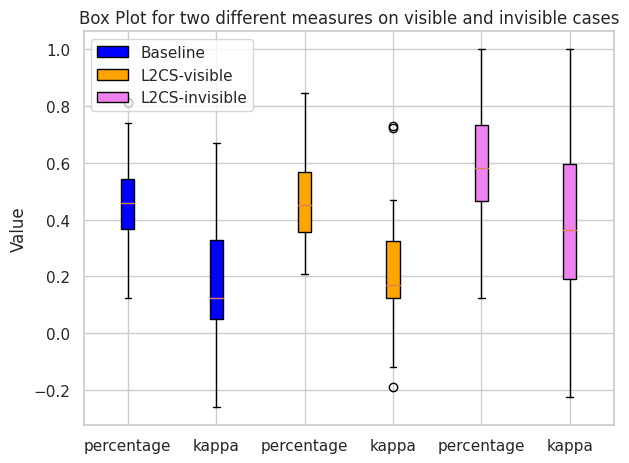

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure()
fig, ax = plt.subplots()
bp1 = ax.boxplot([df_percentage_vis['baseline'], dfkappa_vis_no4['ckappa_manbase']], vert=True, positions=[1, 2], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_vis['l2cs_m2p'], dfkappa_vis_no4['ckappa_manl2cs']], vert=True, positions=[3, 4], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_percentage_invis['l2cs_m2prop'], dfkappa_invis_no4['ckappa_manl2cs']], vert=True, positions=[5, 6], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline', 'L2CS-visible', 'L2CS-invisible'])

# plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for two different measures on visible and invisible cases')
plt.tight_layout()
plt.show()

In [ ]:
print(df_percentage_vis['l2cs_m2p'].mean())
print(df_percentage_vis['baseline'].mean())
print(df_percentage_invis['l2cs_m2prop'].mean())

0.46894911852004867
0.4582406498454989
0.604158460284812


frame level

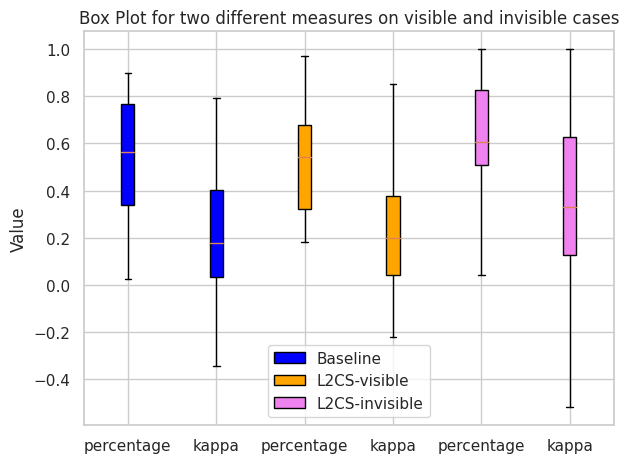

In [ ]:
# Draw the box plot for both DataFrames in one plot
# plt.figure()
fig, ax = plt.subplots()
bp1 = ax.boxplot([df_percentage_vis_frame['Baseline'], dfkappa_vis_no4['ckappa_manbase']], vert=True, positions=[1, 2], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_vis_frame['Gaze_BB'], dfkappa_vis_no4['ckappa_manl2cs']], vert=True, positions=[3, 4], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_percentage_invis_frame['Gaze_BB'], dfkappa_invis_no4['ckappa_manl2cs']], vert=True, positions=[5, 6], labels=['percentage', 'kappa'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline', 'L2CS-visible', 'L2CS-invisible'])

# plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for two different measures on visible and invisible cases')
plt.tight_layout()
plt.show()

In [ ]:
print(df_percentage_vis_frame['Gaze_BB'].mean())
print(df_percentage_vis_frame['Baseline'].mean())
print(df_percentage_invis_frame['Gaze_BB'].mean())

0.5239936157396073
0.5408195175383057
0.6245087872073364


# 21 checked videos (merge three data into one dataframe)

FRAME LEVEL - frame level

In [ ]:
df_ground = pd.read_csv(root + 'annotations_frame_event.csv', header=0, names=['file', 'annotator', 'case', 'framenumber', 'class', 'event_group'])
len(df_ground)

277262

In [ ]:
double_file = 'annotations_double_frame.csv'
df_double = pd.read_csv(root + double_file, header=0, names=['file', 'annotator', 'case', 'framenumber', 'class'])
len(df_double)

127714

In [ ]:
list_daen = df_double[df_double['annotator']=='Daen']['file'].unique().tolist()
print(len(list_daen))
df_one_file = df_double[(df_double['annotator']=='Lin')&(~df_double['file'].isin(list_daen))]
print(df_one_file['file'].iloc[0])
df_double_temp = pd.concat([df_double[df_double['annotator']=='Daen'], df_one_file], axis=0)
print(len(df_double_temp))

20
Proefpersoon22016_Sessie1
63857


In [ ]:
ground_class = []
l2cs_class = []
ground_annotator = []
for f in df_double_temp['file'].unique():
  df_double_ground = df_ground[df_ground['file'] == f]['class'].astype(int).tolist()
  df_double_l2cs = df_all[df_all['file'] == f]['m2prop_class'].astype(int).tolist()
  df_double_ground_annott = df_ground[df_ground['file'] == f]['annotator'].tolist()

  ground_class.extend(df_double_ground)
  l2cs_class.extend(df_double_l2cs)
  ground_annotator.extend(df_double_ground_annott)

print(len(ground_class))
print(len(l2cs_class))
print(len(ground_annotator))
df_double_temp['ground_class'] = ground_class
df_double_temp['l2cs_class'] = l2cs_class
df_double_temp['ground_annotator'] = ground_annotator

63857
63857
63857


In [ ]:
# clean and remove all class 4 from double checked data, ground truth, and l2cs predicted data.
df_double_temp_no4 = df_double_temp[(df_double_temp['class'].isin([0,1,2,3]))&(df_double_temp['ground_class'].isin([0,1,2,3]))&(df_double_temp['l2cs_class'].isin([0,1,2,3]))]
len(df_double_temp_no4)
# df_double_temp_noface = df_double_temp[df_double_temp['l2cs_class'].isin([0,1,2,3])]

56873

In [ ]:
# mapping to event level
manual_event_group = []
# manual_event_group_double = []
# count = 1
for f in df_double_temp_no4['file'].unique():

  list_manual = df_double_temp_no4[df_double_temp_no4['file'] == f]['ground_class'].astype(int).tolist()

  count_dups = [sum(1 for _ in group) for _, group in groupby(list_manual)]
  count = 1
  for cd in count_dups:
      # manual_event_grouop_single.extend([count_dups.index(cd)+1] * cd)
      manual_event_group.extend([count] * cd)
      count += 1
print(len(manual_event_group))
print()
df_double_temp_no4['event_group'] = manual_event_group
# df_double_temp_no4.to_csv(root + '21vids_double_ground_l2cs.csv', index=False)

56873



<ipython-input-91-41ffc9a4f68c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_double_temp_no4['event_group'] = manual_event_group


In [ ]:
df_double_temp_no4_event_frame = df_double_temp_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'annotator', 'ground_annotator', 'ground_class', 'class', 'l2cs_class']].transform(lambda x: x.mode().iloc[0])
len(df_double_temp_no4_event_frame)

56873

Percentage - frame level

In [ ]:
df_percentage_no4_frame = pd.DataFrame(columns=['file', 'case'])
match_human_human = []
match_human_l2cs = []
for f in df_double_temp['file'].unique():
  df_double_temp_no4_event_frame_single = df_double_temp_no4_event_frame[df_double_temp_no4_event_frame['file']==f]
  match_human_human.append((df_double_temp_no4_event_frame_single['ground_class'] == df_double_temp_no4_event_frame_single['class']).sum() / len(df_double_temp_no4_event_frame_single['ground_class']))
  match_human_l2cs.append((df_double_temp_no4_event_frame_single['ground_class'] == df_double_temp_no4_event_frame_single['l2cs_class']).sum() / len(df_double_temp_no4_event_frame_single['ground_class']))
  fcase = list(df_double_temp[df_double_temp['file'] == f]['case'])[0]
  df_percentage_no4_frame.loc[len(df_percentage_no4_frame)] = [f, fcase]

df_percentage_no4_frame['human-human'] = match_human_human
df_percentage_no4_frame['human-model'] = match_human_l2cs

print(df_percentage_no4_frame['human-human'].mean())
print(df_percentage_no4_frame['human-human'].min())
print(df_percentage_no4_frame['human-human'].max())
print()
print(df_percentage_no4_frame['human-model'].mean())
print(df_percentage_no4_frame['human-model'].min())
print(df_percentage_no4_frame['human-model'].max())
# print(df_percentage_no4)
df_percentage_no4_frame.to_csv(root + 'results_analysis/frame_level/percentage_21_mm_ml_no4_frame.csv')

0.8932607398748318
0.5886056027699087
1.0

0.5615945702453919
0.15862708719851576
0.9093484419263456


In [ ]:
df_percentage_no4_frame_clean = df_percentage_no4_frame[df_percentage_no4_frame['human-human']>0.6]

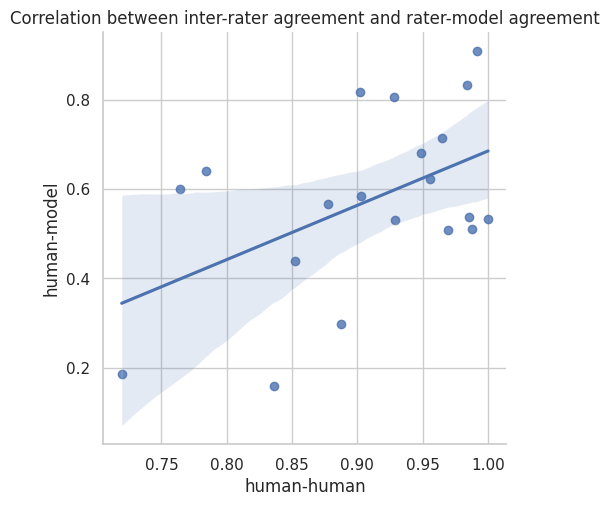

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='human-human', y='human-model', data=df_percentage_no4_frame_clean)
# plt.grid()
plt.title("Correlation between inter-rater agreement and rater-model agreement");

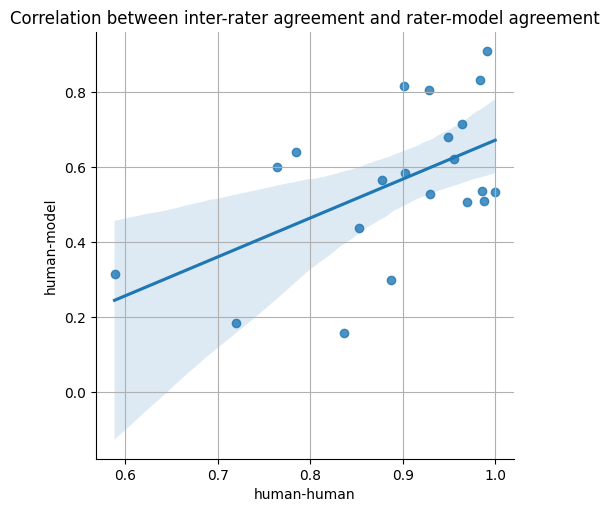

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='human-human', y='human-model', data=df_percentage_no4_frame)
plt.grid()
plt.title("Correlation between inter-rater agreement and rater-model agreement");

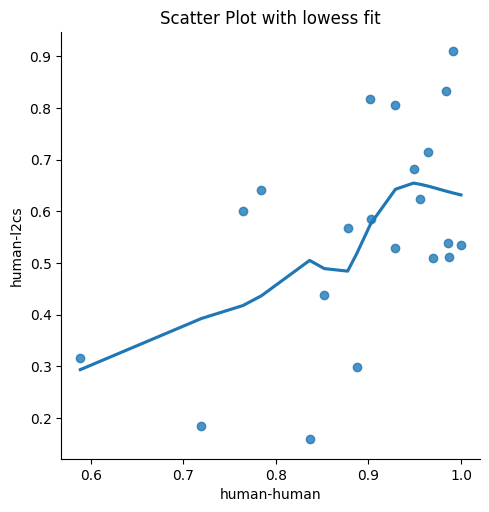

In [ ]:

# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='human-human', y='human-l2cs', data=df_percentage_no4_frame, lowess=True)
plt.title("Scatter Plot with lowess fit");

EVENT LEVEL - event level

21 checked videos
- Cohen's kappa
- percentage
- krippendorff

>>> parameter setting:
df_double_event => event level
df_double => frame level

In [ ]:
df_ground = pd.read_csv(root + 'annotations_frame_event.csv', header=0, names=['file', 'annotator', 'case', 'framenumber', 'class', 'event_group'])
len(df_ground)

277262

In [ ]:
len(df_ground['file'].unique())

90

In [ ]:
double_file = 'annotations_double_frame.csv'
df_double = pd.read_csv(root + double_file, header=0, names=['file', 'annotator', 'case', 'framenumber', 'class'])
len(df_double)

127714

create a temp dataframe to store the manual data and l2cs data and double checked data, with matching only Daen's 20 checked videos and Lin's checked 1 video, 21 videos in total.

In [ ]:
list_daen = df_double[df_double['annotator']=='Daen']['file'].unique().tolist()
print(len(list_daen))
df_one_file = df_double[(df_double['annotator']=='Lin')&(~df_double['file'].isin(list_daen))]
print(df_one_file['file'].iloc[0])
df_double_temp = pd.concat([df_double[df_double['annotator']=='Daen'], df_one_file], axis=0)
print(len(df_double_temp))

20
Proefpersoon22016_Sessie1
63857


add three new columns into df_double_temp

In [ ]:
ground_class = []
l2cs_class = []
ground_annotator = []
for f in df_double_temp['file'].unique():
  df_double_ground = df_ground[df_ground['file'] == f]['class'].astype(int).tolist()
  df_double_l2cs = df_all[df_all['file'] == f]['m2prop_class'].astype(int).tolist()
  df_double_ground_annott = df_ground[df_ground['file'] == f]['annotator'].tolist()

  ground_class.extend(df_double_ground)
  l2cs_class.extend(df_double_l2cs)
  ground_annotator.extend(df_double_ground_annott)

print(len(ground_class))
print(len(l2cs_class))
print(len(ground_annotator))
df_double_temp['ground_class'] = ground_class
df_double_temp['l2cs_class'] = l2cs_class
df_double_temp['ground_annotator'] = ground_annotator

NameError: ignored

In [ ]:
# clean and remove all class 4 from double checked data, ground truth, and l2cs predicted data.
df_double_temp_no4 = df_double_temp[(df_double_temp['class'].isin([0,1,2,3]))&(df_double_temp['ground_class'].isin([0,1,2,3]))&(df_double_temp['l2cs_class'].isin([0,1,2,3]))]
len(df_double_temp_no4)
# df_double_temp_noface = df_double_temp[df_double_temp['l2cs_class'].isin([0,1,2,3])]

56873

In [ ]:
# mapping to event level
manual_event_group = []
# manual_event_group_double = []
# count = 1
for f in df_double_temp_no4['file'].unique():

  list_manual = df_double_temp_no4[df_double_temp_no4['file'] == f]['ground_class'].astype(int).tolist()

  count_dups = [sum(1 for _ in group) for _, group in groupby(list_manual)]
  count = 1
  for cd in count_dups:
      # manual_event_grouop_single.extend([count_dups.index(cd)+1] * cd)
      manual_event_group.extend([count] * cd)
      count += 1
print(len(manual_event_group))
print()
df_double_temp_no4['event_group'] = manual_event_group
# df_double_temp_no4.to_csv(root + '21vids_double_ground_l2cs.csv', index=False)

56873



<ipython-input-82-41ffc9a4f68c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_double_temp_no4['event_group'] = manual_event_group


In [ ]:
df_double_temp_no4_event = df_double_temp_no4.groupby(['file', 'event_group'])[[
    'file', 'case', 'annotator', 'ground_annotator', 'ground_class', 'class', 'l2cs_class']].apply(lambda x: x.mode().iloc[0])
len(df_double_temp_no4_event)

434

# cohen's kappa (21 videos)

In [ ]:
dfkappa_double_no4 = pd.DataFrame(columns=['file', 'case', '1stannotator', '2ndannotator', 'human-human', 'human-human_li', 'human-human_qua', 'human-l2cs'])
for f in df_double_temp['file'].unique():
  df_double_temp_no4_event_single = df_double_temp_no4_event[df_double_temp_no4_event['file'] == f]
  fcase = list(df_double_temp_no4_event_single['case'])[0]
  annotator = list(df_double_temp_no4_event_single['annotator'].unique())
  # annotator1 = df_ground[df_ground['file'] == f]['annotator'].iloc[0]
  annotator1 = df_double_temp_no4_event_single['ground_annotator']
  annotator2 = annotator[0]
#     assert(annotator1 != annotator2)
  rater1 = list(df_double_temp_no4_event_single['ground_class']) # ground truth labels
  rater2 = list(df_double_temp_no4_event_single['class']) # double checked labels
  rater3 = list(df_double_temp_no4_event_single['l2cs_class']) # l2cs predicted labels
  cohenk_double = cohen_kappa_score(rater1, rater2, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
  cohenk_double_li = cohen_kappa_score(rater1, rater2, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='linear')
  cohenk_double_qua = cohen_kappa_score(rater1, rater2, labels=[TABLE, ROBOT, TABLET, ELSEWHERE], weights='quadratic')
  cohenk_manl2cs = cohen_kappa_score(rater1, rater3, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])

  dfkappa_double_no4.loc[len(dfkappa_double_no4)] = [f, fcase, annotator1, annotator2, cohenk_double, cohenk_double_li, cohenk_double_qua, cohenk_manl2cs]

print(dfkappa_double_no4['human-human'].mean())
print(dfkappa_double_no4['human-human'].min())
print(dfkappa_double_no4['human-human'].max())
print()
print(dfkappa_double_no4['human-l2cs'].mean())
print(dfkappa_double_no4['human-l2cs'].min())
print(dfkappa_double_no4['human-l2cs'].max())
# print(dfkappa_double_no4)
dfkappa_double_no4.to_csv(root + 'results_analysis/event_level/ckappa21_mm_ml_no4_with-groundtruth-annotator.csv')

0.6937240573555775
0.3220338983050848
1.0

0.23350115120747766
-0.21348314606741559
0.6564885496183206


In [ ]:
dfkappa_double_no4_vis = dfkappa_double_no4[dfkappa_double_no4['case'] == 'visible']
dfkappa_double_no4_invis = dfkappa_double_no4[dfkappa_double_no4['case'] == 'invisible']
len(dfkappa_double_no4_vis)

11

In [ ]:
df_kappa_double21_vis_no4_melt = dfkappa_double_no4_vis.melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Score")
df_kappa_double21_invis_no4_melt = dfkappa_double_no4_invis.melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Score")
df_kappa_double21_no4_melt = pd.concat([df_kappa_double21_vis_no4_melt, df_kappa_double21_invis_no4_melt], axis=0)
print(len(df_kappa_double21_vis_no4_melt), len(df_kappa_double21_invis_no4_melt), len(df_kappa_double21_no4_melt))

22 20 42


In [ ]:
df_kappa_double21_vis_no4_melt_sorted = dfkappa_double_no4_vis.sort_values('human-human').melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Score")
df_kappa_double21_invis_no4_melt_sorted = dfkappa_double_no4_invis.sort_values('human-human').melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Score")
df_kappa_double21_no4_melt_sorted = pd.concat([df_kappa_double21_vis_no4_melt_sorted, df_kappa_double21_invis_no4_melt_sorted], axis=0)
# df_kappa_double21_vis_no4_melt_sorted

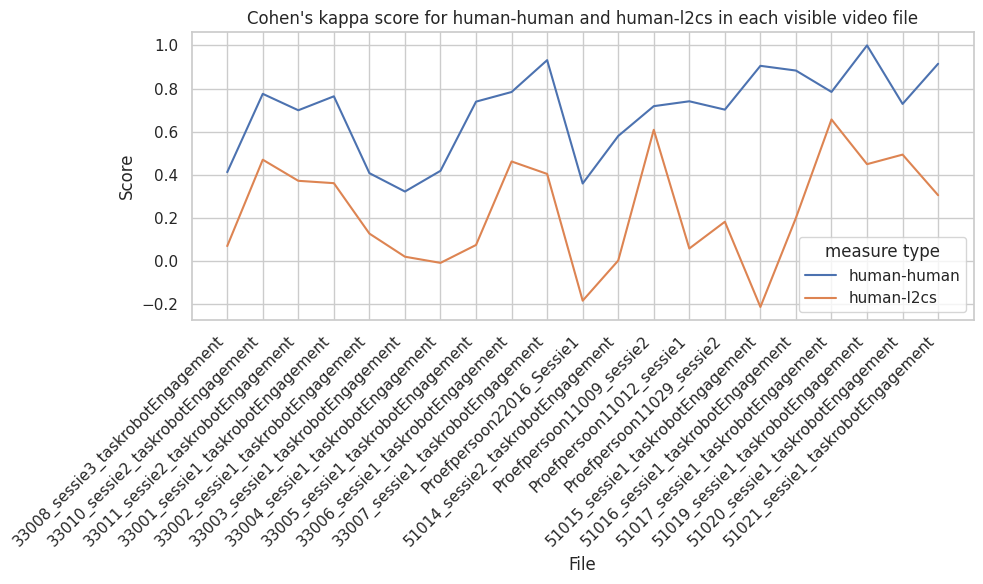

In [ ]:
# original kappa plot
# line plot for double checked visible videos' kappa
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_double21_no4_melt)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Cohen's kappa score for human-human and human-l2cs in each visible video file")
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

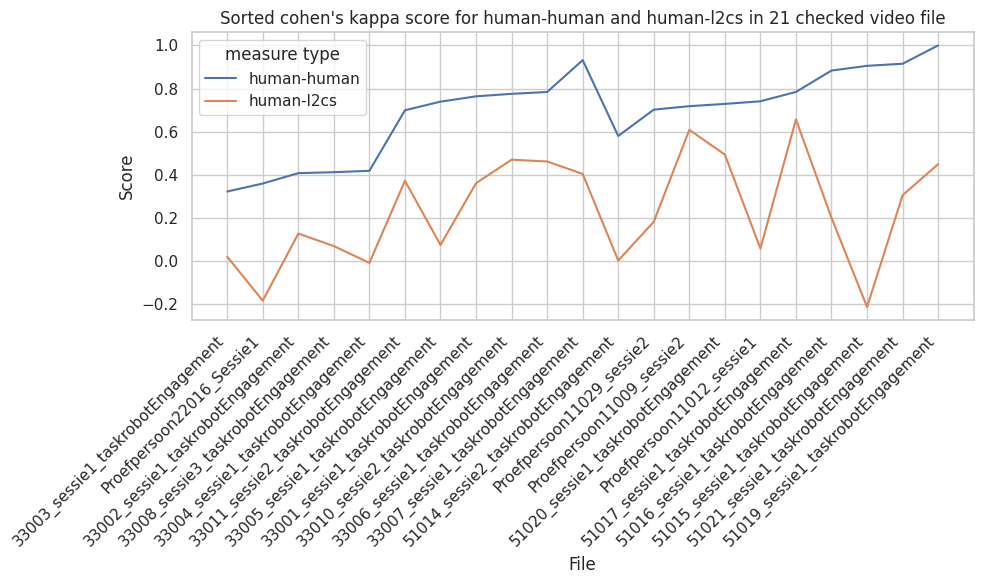

In [ ]:
# sorted human-human kappa
# line plot for double checked visible videos' kappa
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_double21_no4_melt_sorted)
plt.xlabel("File")
plt.ylabel("Score")
plt.title("Sorted cohen's kappa score for human-human and human-l2cs in 21 checked video file")
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

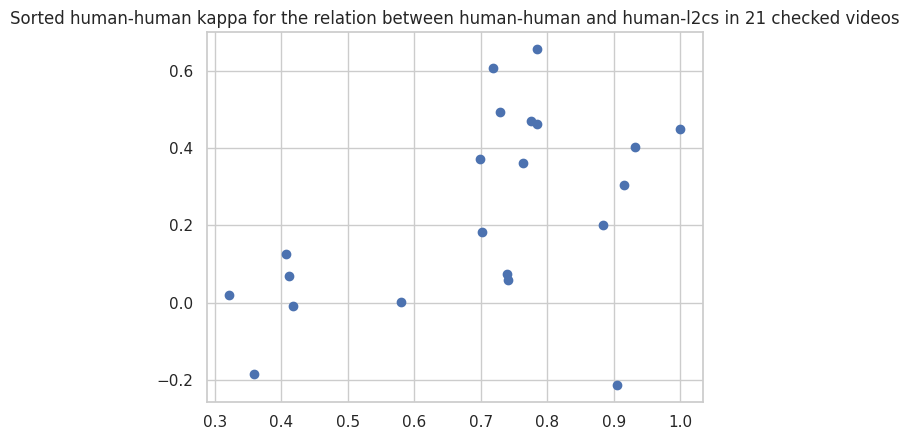

In [ ]:
# scatter plot with sorted human-human kappa
plt.plot(dfkappa_double_no4.sort_values('human-human')['human-human'], dfkappa_double_no4.sort_values('human-human')['human-l2cs'], 'o')
plt.title("Sorted human-human kappa for the relation between human-human and human-l2cs in 21 checked videos")
plt.show()

# percentage (21 videos)

In [ ]:
df_percentage_no4 = pd.DataFrame(columns=['file', 'case'])
match_human_human = []
match_human_l2cs = []
for f in df_double_temp['file'].unique():
  df_double_temp_no4_event_single = df_double_temp_no4_event[df_double_temp_no4_event['file']==f]
  match_human_human.append((df_double_temp_no4_event_single['ground_class'] == df_double_temp_no4_event_single['class']).sum() / len(df_double_temp_no4_event_single['ground_class']))
  match_human_l2cs.append((df_double_temp_no4_event_single['ground_class'] == df_double_temp_no4_event_single['l2cs_class']).sum() / len(df_double_temp_no4_event_single['ground_class']))
  fcase = list(df_double_temp[df_double_temp['file'] == f]['case'])[0]
  df_percentage_no4.loc[len(df_percentage_no4)] = [f, fcase]

df_percentage_no4['human-human'] = match_human_human
df_percentage_no4['human-l2cs'] = match_human_l2cs

print(df_percentage_no4['human-human'].mean())
print(df_percentage_no4['human-human'].min())
print(df_percentage_no4['human-human'].max())
print()
print(df_percentage_no4['human-l2cs'].mean())
print(df_percentage_no4['human-l2cs'].min())
print(df_percentage_no4['human-l2cs'].max())
# print(df_percentage_no4)
df_percentage_no4.to_csv(root + 'results_analysis/event_level/percentage_21_mm_ml_no4_raw.csv')

0.8076064748455404
0.5416666666666666
1.0

0.5190356045352408
0.20833333333333334
0.8


In [ ]:
df_percentage_no4_melt = df_percentage_no4.melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Percentage")

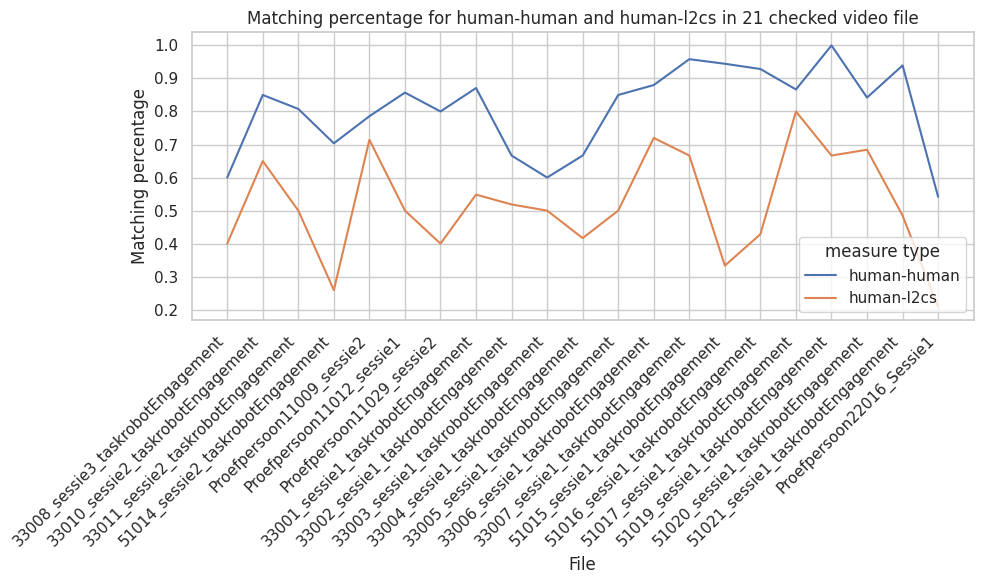

In [ ]:
# original matching percentage
# line plot for 21 double checked videos' percentage
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="measure type", data=df_percentage_no4_melt)
plt.xlabel("File")
plt.ylabel("Matching percentage")
plt.title("Matching percentage for human-human and human-l2cs in 21 checked video file")
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
df_percentage_no4_sorted = df_percentage_no4.sort_values('human-human')
df_percentage_no4_sorted_melt = df_percentage_no4_sorted.melt(id_vars=["file"], value_vars=["human-human", "human-l2cs"],
                                 var_name="measure type", value_name="Percentage")

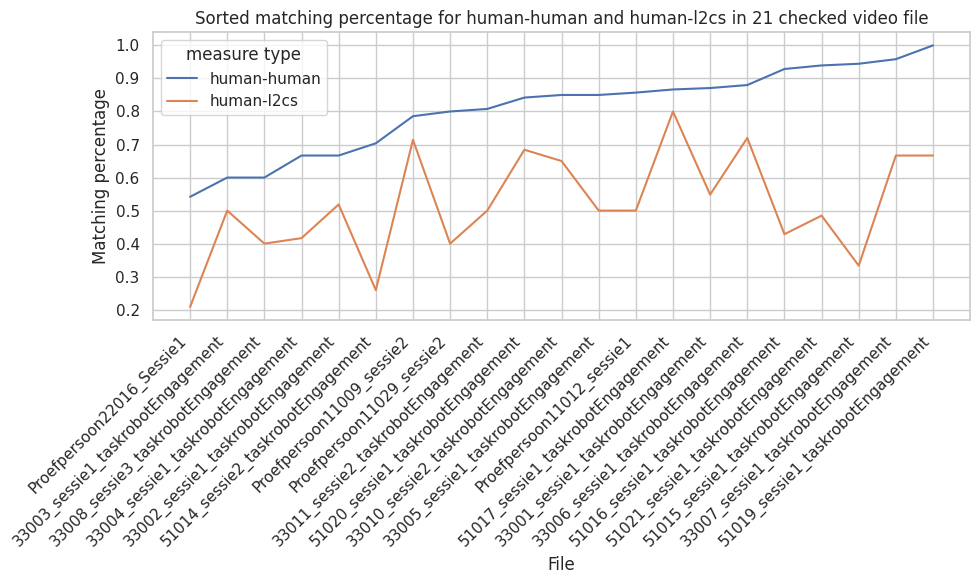

In [ ]:
# sorted human-human matching percentage plot
# line plot for 21 double checked videos' percentage
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Percentage", hue="measure type", data=df_percentage_no4_sorted_melt)
plt.xlabel("File")
plt.ylabel("Matching percentage")
plt.title("Sorted matching percentage for human-human and human-l2cs in 21 checked video file")
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
print(df_percentage_no4_sorted['human-human'].tolist())
print(df_percentage_no4_sorted['human-l2cs'].tolist())

[0.5416666666666666, 0.6, 0.6, 0.6666666666666666, 0.6666666666666666, 0.7037037037037037, 0.7857142857142857, 0.8, 0.8076923076923077, 0.8421052631578947, 0.85, 0.85, 0.8571428571428571, 0.8666666666666667, 0.8709677419354839, 0.88, 0.9285714285714286, 0.9393939393939394, 0.9444444444444444, 0.9583333333333334, 1.0]
[0.20833333333333334, 0.5, 0.4, 0.4166666666666667, 0.5185185185185185, 0.25925925925925924, 0.7142857142857143, 0.4, 0.5, 0.6842105263157895, 0.65, 0.5, 0.5, 0.8, 0.5483870967741935, 0.72, 0.42857142857142855, 0.48484848484848486, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666]


useful

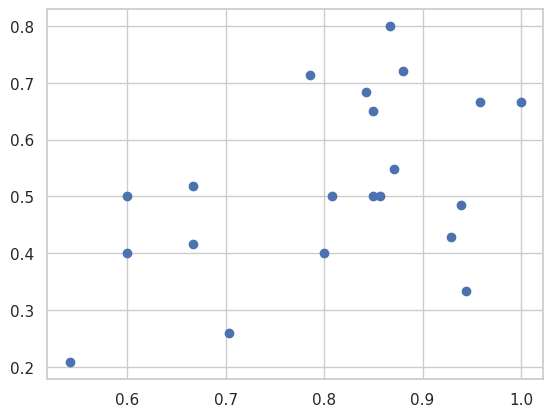

In [ ]:
# scatter plot on the relation between human-human matching and human-l2cs matching
plt.plot(df_percentage_no4_sorted['human-human'], df_percentage_no4_sorted['human-l2cs'], 'o')
plt.show()

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='human-human', y='human-l2cs', data=df_percentage_no4_sorted)
plt.title("Scatter Plot with Linear fit");

# krippendorff's alpha score (21 videos)

In [ ]:
krippen_manl2cs = []
krippen_manman = []
# manual >>>
# df_vis_clean_event['class']
# l2cs >>>
# df_vis_clean_event['m2prop_class']
# baseline >>>
# df_vis_clean_event['base_class']

for f in df_double_temp_no4_event['file'].unique():
    anns_manl2cs = []
    anns_manman = []
    df_double_temp_no4_event_single = df_double_temp_no4_event[df_double_temp_no4_event['file'] == f]
    manual = list(df_double_temp_no4_event_single['ground_class'])
    double = list(df_double_temp_no4_event_single['class'])
    l2cs = list(df_double_temp_no4_event_single['l2cs_class'])

    anns_manl2cs.append(manual)
    anns_manl2cs.append(l2cs)
    anns_manman.append(manual)
    anns_manman.append(double)

    krippen_manl2cs.append(kd.alpha(anns_manl2cs, level_of_measurement='nominal'))
    krippen_manman.append(kd.alpha(anns_manman, level_of_measurement='nominal'))


In [ ]:
print(krippen_manman)
print(np.array(krippen_manman).mean())
print()
print(krippen_manl2cs)
print(np.array(krippen_manl2cs).mean())
print()

[0.766953199617956, 0.4154411764705882, 0.3333333333333335, 0.426829268292683, 0.7450980392156863, 0.7872648335745297, 0.9329529243937232, 0.4219269102990034, 0.777988614800759, 0.6982248520710059, 0.5863414634146342, 0.9076517150395779, 0.8870292887029289, 0.7890909090909091, 1.0, 0.7338129496402878, 0.9160748870238864, 0.7235494880546075, 0.7452830188679245, 0.71, 0.34639696586599256]
0.6976782779890485

[0.324901185770751, -0.04552352048558417, -0.09550561797752821, -0.08401976935749578, -0.05978260869565233, 0.4698608964451314, 0.3691275167785234, 0.0076045627376425395, 0.4709302325581395, 0.3227783452502553, -0.0772357723577235, -0.22448979591836715, 0.1428571428571428, 0.6666666666666667, 0.4631578947368421, 0.4919908466819223, 0.29483088704530946, 0.6210526315789473, -0.09883720930232553, 0.17665615141955826, -0.2886002886002885]
0.18325811323008892



In [ ]:
df_krip_21vids = pd.DataFrame()
df_krip_21vids['file'] = df_double_temp_no4_event['file'].unique().tolist()
df_krip_21vids['krip_manl2cs'] = krippen_manl2cs
df_krip_21vids['krip_manman'] = krippen_manman

df_krip_21vids.to_csv(root + 'results_analysis/event_level/krip_21vids.csv')

In [ ]:
df_krip_melt_21 = df_krip_21vids.melt(id_vars=["file"], value_vars=["krip_manman", "krip_manl2cs"],
                                 var_name="method", value_name="Score")

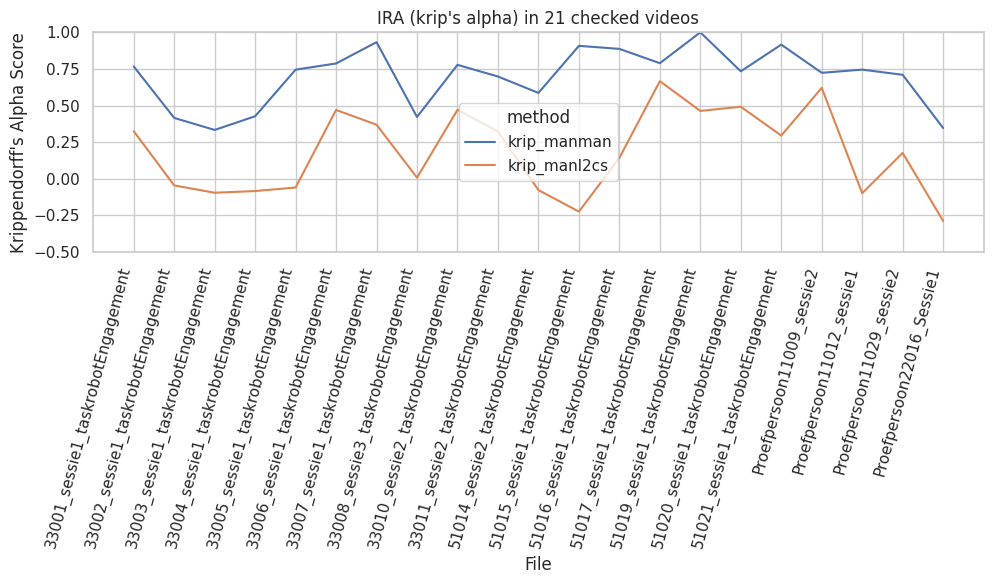

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_21)
plt.xlabel("File")
plt.ylabel("Krippendorff's Alpha Score")
plt.title("IRA (krip's alpha) in 21 checked videos")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
df_krip_21vids_sorted = df_krip_21vids.sort_values('krip_manman')

df_krip_melt_21_sorted = df_krip_21vids_sorted.melt(id_vars=["file"], value_vars=["krip_manman", "krip_manl2cs"],
                                 var_name="method", value_name="Score")

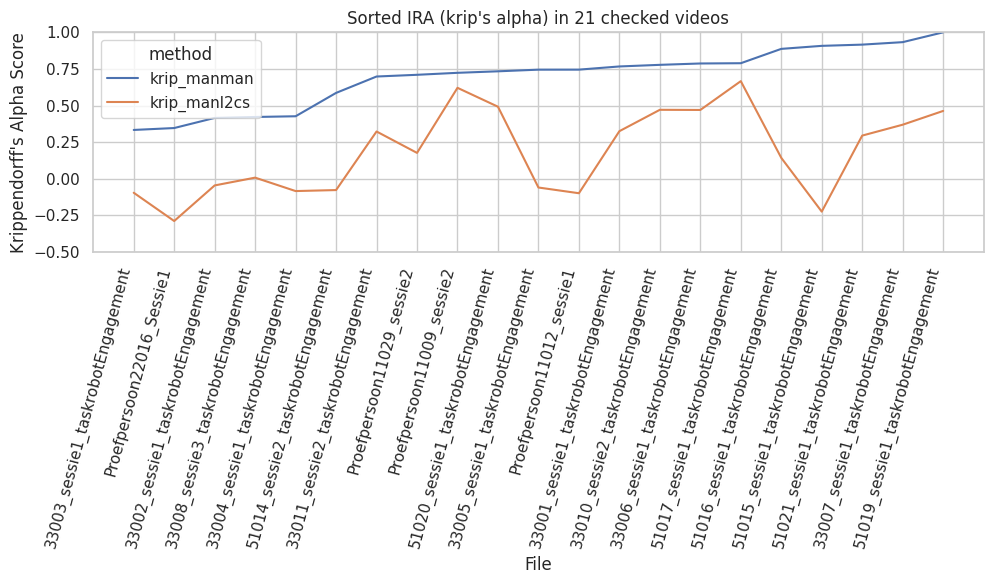

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_21_sorted)
plt.xlabel("File")
plt.ylabel("Krippendorff's Alpha Score")
plt.title("Sorted IRA (krip's alpha) in 21 checked videos")
plt.xticks(rotation=75, ha='right')
plt.ylim(-0.5, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
print(df_krip_21vids_sorted['krip_manman'].tolist())
print(df_krip_21vids_sorted['krip_manl2cs'].tolist())

[0.3333333333333335, 0.34639696586599256, 0.4154411764705882, 0.4219269102990034, 0.426829268292683, 0.5863414634146342, 0.6982248520710059, 0.71, 0.7235494880546075, 0.7338129496402878, 0.7450980392156863, 0.7452830188679245, 0.766953199617956, 0.777988614800759, 0.7872648335745297, 0.7890909090909091, 0.8870292887029289, 0.9076517150395779, 0.9160748870238864, 0.9329529243937232, 1.0]
[-0.09550561797752821, -0.2886002886002885, -0.04552352048558417, 0.0076045627376425395, -0.08401976935749578, -0.0772357723577235, 0.3227783452502553, 0.17665615141955826, 0.6210526315789473, 0.4919908466819223, -0.05978260869565233, -0.09883720930232553, 0.324901185770751, 0.4709302325581395, 0.4698608964451314, 0.6666666666666667, 0.1428571428571428, -0.22448979591836715, 0.29483088704530946, 0.3691275167785234, 0.4631578947368421]


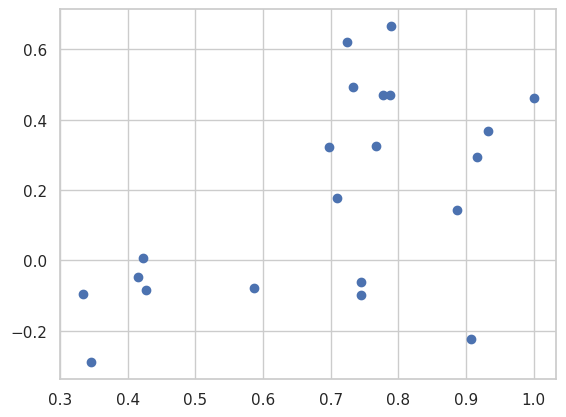

In [ ]:
# scatter plot on the relation between human-human and human-l2cs on Krippendorff's alpha score
plt.plot(df_krip_21vids_sorted['krip_manman'], df_krip_21vids_sorted['krip_manl2cs'], 'o')
plt.show()

box plot for percentage, Kappa, krip (21 videos)

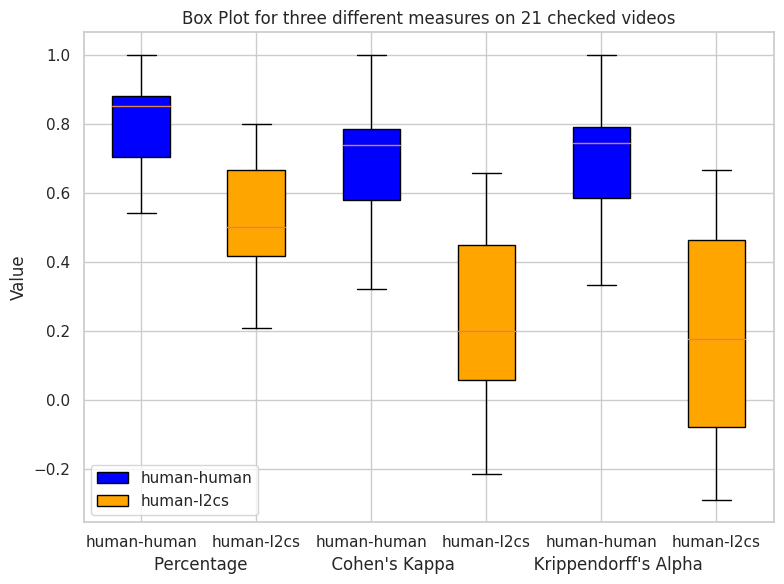

In [ ]:
# Draw the box plot
# plt.figure()
fig, ax = plt.subplots(figsize=(8, 6))
bp1 = ax.boxplot([df_percentage_no4['human-human'], dfkappa_double_no4['human-human'], df_krip_21vids['krip_manman']], vert=True, positions=[1, 3, 5], labels=['human-human', 'human-human', 'human-human'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_no4['human-l2cs'], dfkappa_double_no4['human-l2cs'], df_krip_21vids['krip_manl2cs']], vert=True, positions=[2, 4, 6], labels=['human-l2cs', 'human-l2cs', 'human-l2cs'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['human-human', 'human-l2cs'])

plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for three different measures on 21 checked videos')
plt.tight_layout()
plt.show()

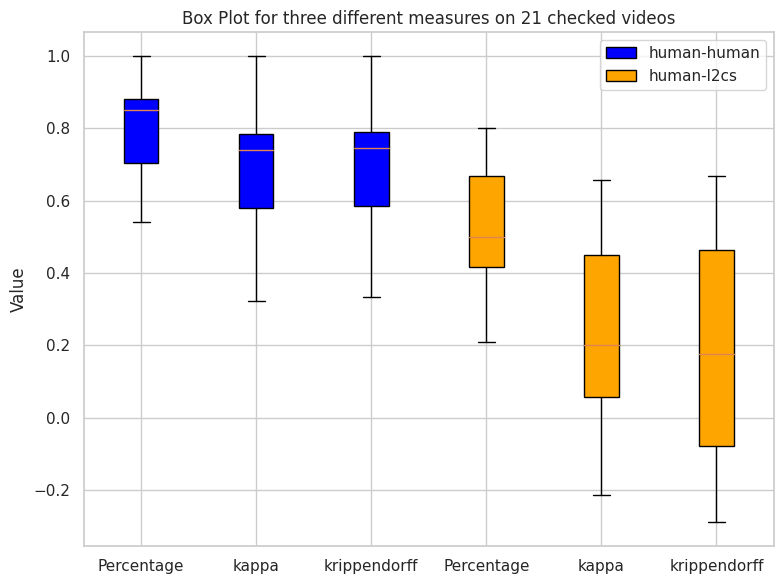

In [ ]:
# Draw the box plot
# plt.figure()
fig, ax = plt.subplots(figsize=(8, 6))
bp1 = ax.boxplot([df_percentage_no4['human-human'], dfkappa_double_no4['human-human'], df_krip_21vids['krip_manman']], vert=True, positions=[1, 2, 3], labels=['Percentage', 'kappa', 'krippendorff'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_percentage_no4['human-l2cs'], dfkappa_double_no4['human-l2cs'], df_krip_21vids['krip_manl2cs']], vert=True, positions=[4, 5, 6], labels=['Percentage', 'kappa', 'krippendorff'], patch_artist=True, boxprops=dict(facecolor='orange'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['human-human', 'human-l2cs'])

# plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("Value")
plt.title('Box Plot for three different measures on 21 checked videos')
plt.tight_layout()
plt.show()

clean the double checked video data file with removing all class 4 in manual annotation

In [ ]:
# # transform the cleaned manual class with grouped event
# most_frequent_value = df_double.groupby('event_group')['class'].transform(lambda x: x.mode().iloc[0])
# most_frequent_value_no4 = df_double_no4.groupby('event_group')['class'].transform(lambda x: x.mode().iloc[0])
# # Add the most frequent value as a new column in the DataFrame
# df_double['class_event'] = most_frequent_value
# df_double_no4['class_event'] = most_frequent_value_no4

In [ ]:
# df_double_event = df_double.groupby('event_group')['class'].apply(lambda x: x.mode().iloc[0])
# df_double_no4_event = df_double_no4.groupby('event_group')['class'].apply(lambda x: x.mode().iloc[0])


In [ ]:
# df_double.to_csv(root + 'double_frame_event.csv', index=False)
# df_double_no4.to_csv(root + 'double_frame_event_no4.csv', index=False)

In [ ]:
# print(len(most_frequent_value_no4))

123622


In [ ]:
# print(len(df_double_no4['class']), len(df_double_no4['class_event']))

123622 123622


In [ ]:
# print(df_double_no4['class'].equals(df_double_no4['class_event']))

False


21 videos Kappa (without class 4)

concat human-human and human-l2cs cohen's kappa files (21 checked visible file with invisible file)

In [ ]:
# df_mm = pd.read_csv(root + 'results_analysis/event_level/ckappa_mm.csv')
# df_mm_no4 = pd.read_csv(root + 'results_analysis/event_level/ckappa_mm_no4.csv')

In [ ]:
# print(len(df_mm))

In [ ]:
# df_mlb_vis = pd.read_csv(root + 'results_analysis/event_level/ckappa_vis_mlb.csv')
# df_mlb_vis_no4 = pd.read_csv(root + 'results_analysis/event_level/ckappa_vis_mlb_no4.csv')

In [ ]:
# df_ml_invis = pd.read_csv(root + 'results_analysis/event_level/ckappa_invis_ml.csv')
# df_ml_invis_no4 = pd.read_csv(root + 'results_analysis/event_level/ckappa_invis_ml_no4.csv')

In [ ]:
# df_ml = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua'])
# df_ml_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua'])

# df_ml = pd.concat([df_mlb_vis[['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua']], df_ml_invis[['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua']]], axis=0)
# df_ml_no4 = pd.concat([df_mlb_vis_no4[['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua']], df_ml_invis_no4[['file', 'case', 'ckappa_manl2cs', 'ckappa_manl2cs_li', 'ckappa_manl2cs_qua']]], axis=0)

In [ ]:
# df_ml.to_csv(root + 'results_analysis/event_level/ckappa_ml_all.csv')
# df_ml_no4.to_csv(root + 'results_analysis/event_level/ckappa_ml_no4_all.csv')

In [ ]:
# vid_21 = df_mm['file'].unique().tolist()

# df_ml_21 = df_ml[df_ml['file'].isin(vid_21)]
# df_ml_21_no4 = df_ml_no4[df_ml_no4['file'].isin(vid_21)]

# # df_ml_21.to_csv(root + 'results_analysis/event_level/ckappa_ml_21.csv')
# # df_ml_21_no4.to_csv(root + 'results_analysis/event_level/ckappa_ml_21_no4.csv')

In [ ]:
# print(len(df_ml_21))

In [ ]:
# df_21 = pd.merge(df_mm[['file', 'case', 'ckappa_double', 'ckappa_double_li', 'ckappa_double_qua']], df_ml_21, on=['file', 'case'], how='outer')
# df_21_no4 = pd.merge(df_mm_no4[['file', 'case', 'ckappa_double', 'ckappa_double_li', 'ckappa_double_qua']], df_ml_21_no4, on=['file', 'case'], how='outer')

# # df_21.to_csv(root + 'results_analysis/event_level/ckappa_21.csv')
# # df_21_no4.to_csv(root + 'results_analysis/event_level/ckappa_21_no4.csv')

In [ ]:
# print(df_21)

Draw line plot for human-human and human-l2cs for 21 videos

In [ ]:
# df_21_no4.rename(columns = {'ckappa_double':'human-human', 'ckappa_manl2cs':'human-l2cs', 'ckappa_double_li':'human-human_li', 'ckappa_manl2cs_li':'human-l2cs_li', 'ckappa_double_qua':'human-human_qua', 'ckappa_manl2cs_qua':'human-l2cs_qua'}, inplace = True)


In [ ]:
# df_21_no4_melt = df_21_no4.melt(id_vars=['file'], value_vars=['human-human', 'human-l2cs'], var_name='type', value_name='Score')

# sns.set(style='whitegrid')
# plt.figure(figsize=(10,6))
# sns.lineplot(x="file", y="Score", hue="type", data=df_21_no4_melt)
# plt.xlabel('File')
# plt.ylabel("Cohen's kappa score")
# plt.title("Inter Rater Aggrement on 21 double checked videos (without class 4)")
# plt.xticks(rotation=45, ha='right')
# plt.ylim(-0.5,1)
# plt.tight_layout()
# plt.show()

# Fixation time

FRAME LEVEL - frame level

In [ ]:
analysis_root = root + 'results_analysis/frame_level/'
pct_vis_frame = pd.read_csv(analysis_root + 'percentage_vis_raw_frame.csv', header=0, names=['file', 'case', 'Gaze_BB', 'Baseline'])
pct_invis_frame = pd.read_csv(analysis_root + 'percentage_invis_raw_frame.csv', header=0, names=['file', 'case', 'L2CS', 'Gaze_BB'])

In [ ]:
# concat vis and invis percentage file into one dataframe
pct_all_frame = pd.concat([pct_vis_frame, pct_invis_frame], axis=0)

In [ ]:
# first to sort based on the filename, so the same child will be grouped by every successive 3 videos
pct_all_sorted_frame = pct_all_frame.sort_values('file')

In [ ]:
# Calculate the number of groups with three videos
num_child = len(pct_all_sorted_frame) // 3

# Reshape the DataFrame into groups of three videos each
groups = [pct_all_sorted_frame.iloc[i * 3: (i + 1) * 3] for i in range(num_child)]

# Calculate the average for each group
averages_pct = [group["Gaze_BB"].mean() for group in groups]

# If there are remaining values, calculate the average for the last group
if len(pct_all_sorted_frame) % 3 != 0:
    last_group = pct_all_sorted_frame.iloc[-(len(pct_all_sorted_frame) % 3):]
    averages_pct.append(last_group["Gaze_BB"].mean())

In [ ]:
df_percentage_l2cs_frame = pd.DataFrame(columns=['child_id', 'percentage'])
df_percentage_l2cs_frame['child_id'] = child_list
df_percentage_l2cs_frame['percentage'] = averages_pct
print(df_percentage_l2cs_frame['percentage'].mean())

0.5742512014734719


In [ ]:
df_joint_frame = df_fixation_sorted.merge(df_percentage_l2cs_frame, on=['child_id'], how='left')

In [ ]:
df_joint_frame_clean = df_joint_frame[df_joint_frame['avg_fixation_child']<13]

Text(0.5, 1.0, "Correlation between child's fixation time and model accuracy")

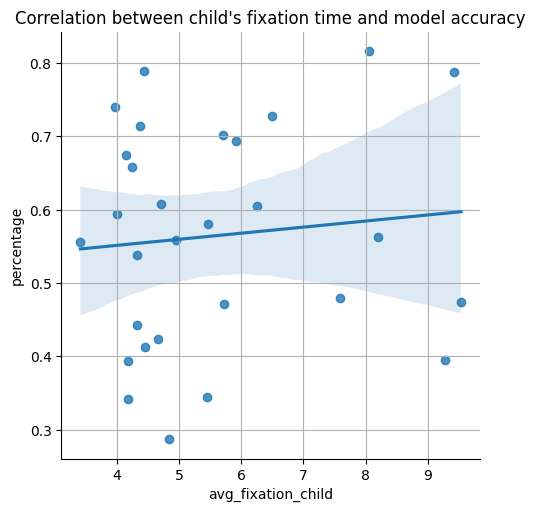

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='avg_fixation_child', y='percentage', data=df_joint_frame_clean)
plt.grid()
plt.title("Correlation between child's fixation time and model accuracy")

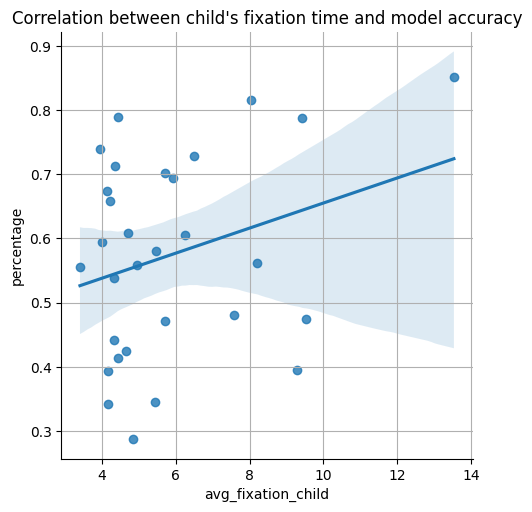

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='avg_fixation_child', y='percentage', data=df_joint_frame)
plt.grid()
plt.title("Correlation between child's fixation time and model accuracy");

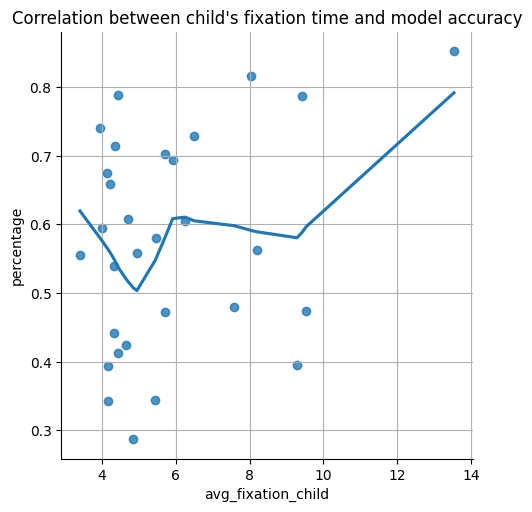

In [ ]:
# Linear - Line of best fit
# df=pd.read_csv(url)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='avg_fixation_child', y='percentage', data=df_joint_frame, lowess=True)
plt.grid()
plt.title("Correlation between child's fixation time and model accuracy");

EVENT LEVEL - event level

Fixation time

In [ ]:
# print(len(vid_list_cleaned))

84


In [ ]:
vid_stats_file = '/content/drive/MyDrive/gaze_data/results/vidstat.csv'
vid_stats = pd.read_csv(vid_stats_file, header=0, names=['file', 'frames', 'rate'])

In [ ]:
print(len(vid_stats))

90


In [ ]:
# list_event_duration = []
# for f in vid_list_cleaned:
#     df_all_no4_single = df_all_no4[df_all_no4['file'] == f].copy()
#     df_all_event_no4_single = df_all_event_no4[df_all_event_no4['file'] == f].copy()
# #     frame_number = len(df_all_no4_single)
#     frame_number = vid_stats[vid_stats['file'] == f]['frames'].astype(int)
#     rate = vid_stats[vid_stats['file'] == f]['rate'].astype(int)
#     event_number = len(df_all_event_no4_single)

#     # calculate frames number for each event
#     list_class = df_all_no4_single['class'].astype(int).tolist()
#     count_dups = [sum(1 for _ in group) for _, group in groupby(list_class)]

#     list_event_duration_single = []
#     for cd in count_dups:
#         event_duration = cd / rate
#         list_event_duration_single.append(event_duration)
#     list_event_duration.extend(list_event_duration_single)

# df_all_event_no4['event_duration']

In [ ]:
list_event_duration = []
for f in vid_stats['file'].unique():
    frame_number = vid_stats[vid_stats['file'] == f]['frames'].iloc[0].astype(int)
    rate = vid_stats[vid_stats['file'] == f]['rate'].iloc[0].astype(int)
    event_number = len(df_all_event[df_all_event['file'] == f])

    avg_fixation_time = (frame_number / rate) / event_number # average duration time for each event

    list_event_duration.append(avg_fixation_time)
# print(list_event_duration)
vid_stats['avg_fixation'] = list_event_duration

In [ ]:
print(vid_stats)

                                 file  frames  rate  avg_fixation
0   33001_sessie1_taskrobotEngagement    2682  25.0      3.460645
1   33001_sessie2_taskrobotEngagement    8630  25.0      5.951724
2   33001_sessie3_taskrobotEngagement    2137  25.0      3.287692
3   33002_sessie1_taskrobotEngagement    2044  25.0      3.028148
4   33002_sessie2_taskrobotEngagement    3331  25.0      4.298065
..                                ...     ...   ...           ...
40          Proefpersoon11012_sessie2    3988  30.0      4.747619
41          Proefpersoon11012_Sessie3    3928  30.0     26.186667
42          Proefpersoon11029_Sessie1    3658  30.0      5.301449
43          Proefpersoon11029_sessie2    3658  30.0      6.417544
44          Proefpersoon11029_sessie3    3658  30.0      3.126496

[90 rows x 4 columns]


In [ ]:
vid_stats_sorted = vid_stats.sort_values('file')

In [ ]:
vid_list = vid_stats_sorted['file'].unique().tolist()

In [ ]:
# Calculate the number of groups with three videos
num_child = len(vid_stats_sorted) // 3

# Reshape the DataFrame into groups of three videos each
groups = [vid_stats_sorted.iloc[i * 3: (i + 1) * 3] for i in range(num_child)]

# Calculate the average for each group
averages = [group["avg_fixation"].mean() for group in groups]

# If there are remaining values, calculate the average for the last group
if len(vid_stats_sorted) % 3 != 0:
    last_group = vid_stats_sorted.iloc[-(len(vid_stats_sorted) % 3):]
    averages.append(last_group["avg_event_duration"].mean())

In [ ]:
# averages_sorted = sorted(averages)

In [ ]:
# vid_list

In [ ]:
child_list = []
vid_list = vid_stats_sorted['file'].unique().tolist()
for i in range(0, len(vid_list), 3):
    if vid_list[i].startswith('P'):
        child_id = vid_list[i][:17]
    else:
        child_id = vid_list[i][:5]

    if child_id not in child_list:
        child_list.append(child_id)
        continue
    else:
        if vid_list[i-1].startswith('P'):
            child_id = vid_list[i-1][:17]
        else:
            child_id = vid_list[i-1][:5]

        if child_id not in child_list:
            child_list.append(child_id)
            continue
        else:
            if vid_list[i+1].startswith('P'):
                child_id = vid_list[i+1][:17]
            else:
                child_id = vid_list[i+1][:5]

            if child_id not in child_list:
                child_list.append(child_id)
                continue
            else:
                print(child_id)

print(len(child_list))

30


In [ ]:
print(len(averages))

30


In [ ]:
df_fixation = pd.DataFrame(columns=['child_id', 'avg_fixation_child'])
df_fixation['child_id'] = child_list
df_fixation['avg_fixation_child'] = averages

In [ ]:
print(df_fixation['avg_fixation_child'].mean())

5.857326172818754


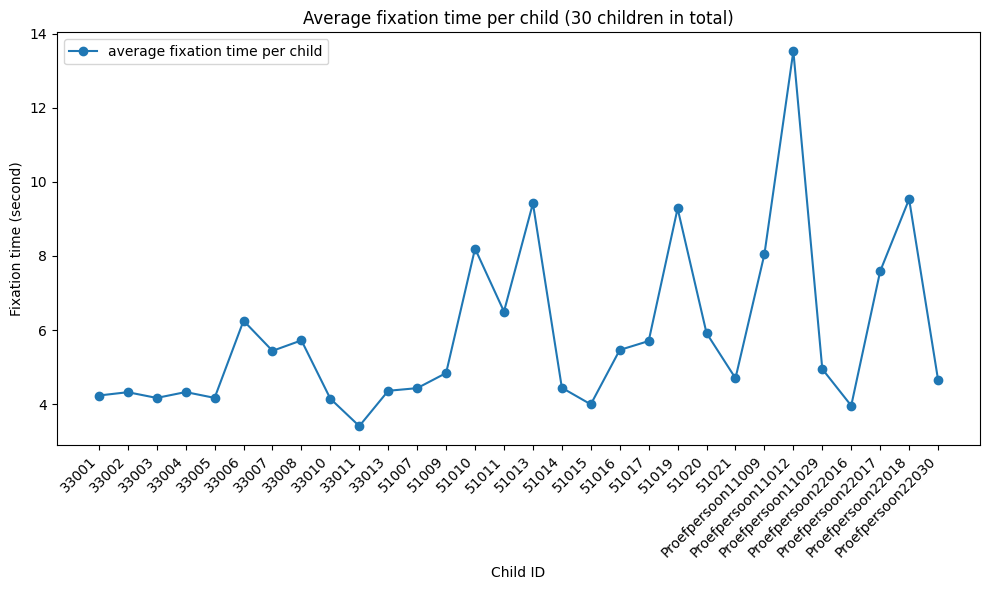

In [ ]:
plt.figure(figsize=(10,6))
x_labels = df_fixation['child_id'].unique().tolist()
plt.plot(x_labels, df_fixation['avg_fixation_child'], label="average fixation time per child", marker='o')
plt.xlabel("Child ID")
plt.ylabel("Fixation time (second)")
plt.title("Average fixation time per child (30 children in total)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# x y axis for the line plot above
print(f"{x_labels}") # x-axis
print(f"{df_fixation['avg_fixation_child']}") # y-axis

['33001', '33002', '33003', '33004', '33005', '33006', '33007', '33008', '33010', '33011', '33013', '51007', '51009', '51010', '51011', '51013', '51014', '51015', '51016', '51017', '51019', '51020', '51021', 'Proefpersoon11009', 'Proefpersoon11012', 'Proefpersoon11029', 'Proefpersoon22016', 'Proefpersoon22017', 'Proefpersoon22018', 'Proefpersoon22030']
0      4.233354
1      4.322812
2      4.168189
3      4.326575
4      4.169221
5      6.252778
6      5.439335
7      5.721846
8      4.147220
9      3.408036
10     4.361027
11     4.432211
12     4.840015
13     8.199952
14     6.500422
15     9.420278
16     4.442024
17     3.994774
18     5.462967
19     5.703937
20     9.283778
21     5.917471
22     4.700281
23     8.048298
24    13.532169
25     4.948496
26     3.959513
27     7.587614
28     9.534683
29     4.660513
Name: avg_fixation_child, dtype: float64


In [ ]:
df_fixation_sorted = df_fixation.sort_values('avg_fixation_child')

In [ ]:
df_fixa_sorted_clean = df_fixation_sorted[df_fixation_sorted['avg_fixation_child']<13]
len(df_fixa_sorted_clean)

29

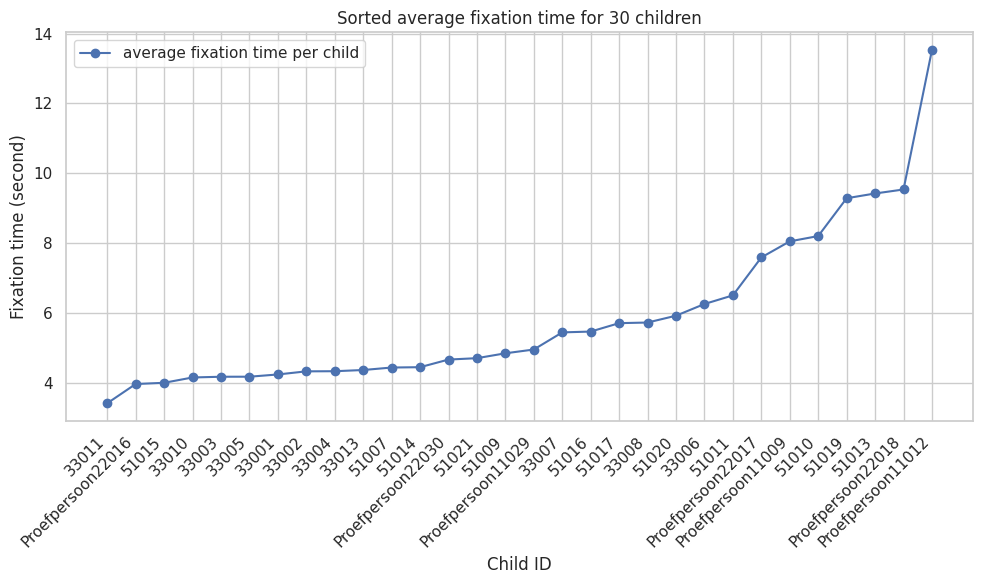

In [ ]:
plt.figure(figsize=(10,6))
x_labels = df_fixation_sorted['child_id'].unique().tolist()
plt.plot(x_labels, df_fixation_sorted['avg_fixation_child'], label="average fixation time per child", marker='o')
plt.xlabel("Child ID")
plt.ylabel("Fixation time (second)")
plt.title("Sorted average fixation time for 30 children")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

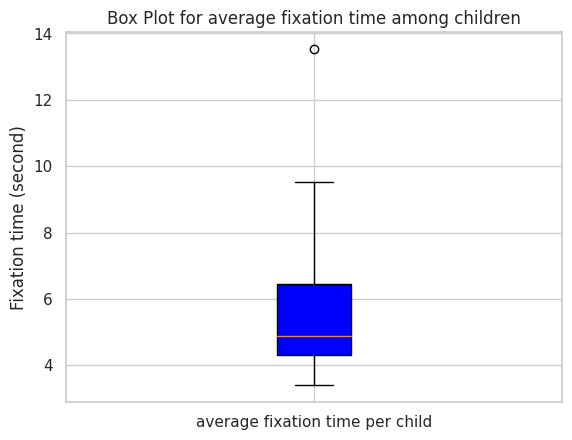

In [ ]:
plt.figure()

bp1 = plt.boxplot(df_fixation['avg_fixation_child'], vert=True, positions=[1], labels=['average fixation time per child'], patch_artist=True, boxprops=dict(facecolor='blue'))

# plt.xlabel("")
plt.ylabel("Fixation time (second)")
plt.title('Box Plot for average fixation time among children')
# plt.legend(bp1["boxes"][0], [''])
plt.show()

L2CS matching percentage with manual (30 children)

In [ ]:
analysis_root = root + 'results_analysis/event_level/'
pct_vis = pd.read_csv(analysis_root + 'percentage_vis_rawfloat.csv', header=0, names=['file', 'case', 'l2cs_m2p', 'baseline'])
pct_invis = pd.read_csv(analysis_root + 'percentage_invis_rawfloat.csv', header=0, names=['file', 'case', 'l2cs_org', 'l2cs_m2p'])

In [ ]:
# pct_vis

In [ ]:
# concat vis and invis percentage file into one dataframe
pct_all = pd.concat([pct_vis, pct_invis], axis=0)

In [ ]:
pct_all

file       case  l2cs_m2p  baseline  l2cs_org
0   33001_sessie1_taskrobotEngagement    visible  0.580645  0.741935       NaN
1   33001_sessie2_taskrobotEngagement    visible  0.518519  0.814815       NaN
2   33001_sessie3_taskrobotEngagement    visible  0.423077  0.730769       NaN
3   33002_sessie1_taskrobotEngagement    visible  0.518519  0.481481       NaN
4   33002_sessie2_taskrobotEngagement    visible  0.451613  0.322581       NaN
..                                ...        ...       ...       ...       ...
40          Proefpersoon11012_sessie1  invisible  0.466667       NaN  0.533333
41          Proefpersoon11012_sessie2  invisible  0.555556       NaN  0.555556
42          Proefpersoon11029_Sessie1  invisible  0.789474       NaN  0.684211
43          Proefpersoon11029_sessie2  invisible  0.357143       NaN  0.357143
44          Proefpersoon11029_sessie3  invisible  0.516129       NaN  0.548387

[90 rows x 5 columns]

In [ ]:
# first to sort based on the filename, so the same child will be grouped by every successive 3 videos
pct_all_sorted = pct_all.sort_values('file')

In [ ]:
# print(pct_all_sorted['file'].unique().tolist())

In [ ]:
# Calculate the number of groups with three videos
num_child = len(pct_all_sorted) // 3

# Reshape the DataFrame into groups of three videos each
groups = [pct_all_sorted.iloc[i * 3: (i + 1) * 3] for i in range(num_child)]

# Calculate the average for each group
averages_pct = [group["l2cs_m2p"].mean() for group in groups]

# If there are remaining values, calculate the average for the last group
if len(pct_all_sorted) % 3 != 0:
    last_group = pct_all_sorted.iloc[-(len(pct_all_sorted) % 3):]
    averages_pct.append(last_group["l2cs_m2p"].mean())

In [ ]:
# averages_pct

In [ ]:
df_percentage_l2cs = pd.DataFrame(columns=['child_id', 'percentage'])
df_percentage_l2cs['child_id'] = child_list
df_percentage_l2cs['percentage'] = averages_pct
print(df_percentage_l2cs['percentage'].mean())

0.5365537894024303


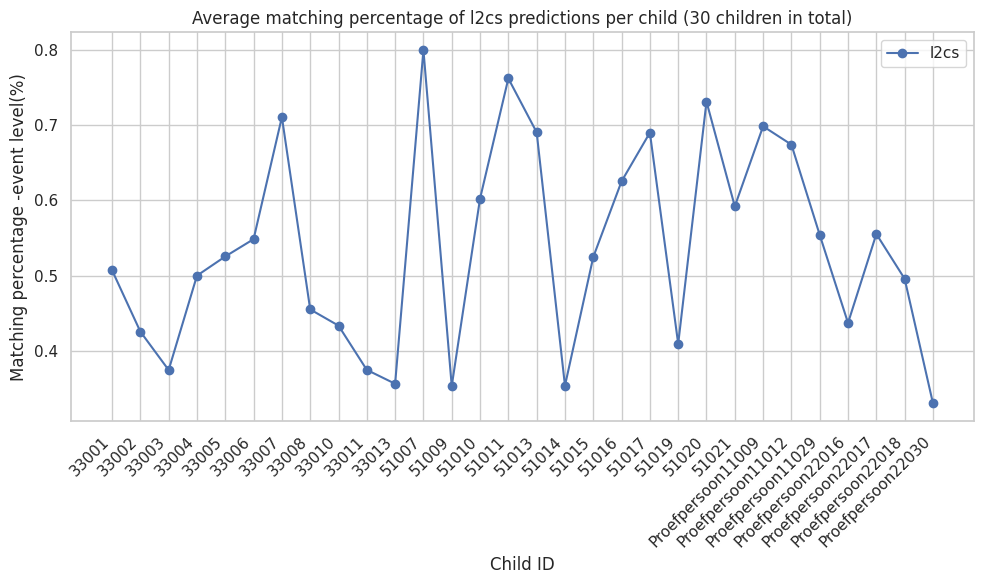

In [ ]:
plt.figure(figsize=(10,6))
x_labels = df_percentage_l2cs['child_id'].unique().tolist()
plt.plot(x_labels, df_percentage_l2cs['percentage'], label="l2cs", marker='o')
plt.xlabel("Child ID")
plt.ylabel("Matching percentage -event level(%)")
plt.title("Average matching percentage of l2cs predictions per child (30 children in total)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_percentage_l2cs_sorted = df_percentage_l2cs.sort_values('percentage')

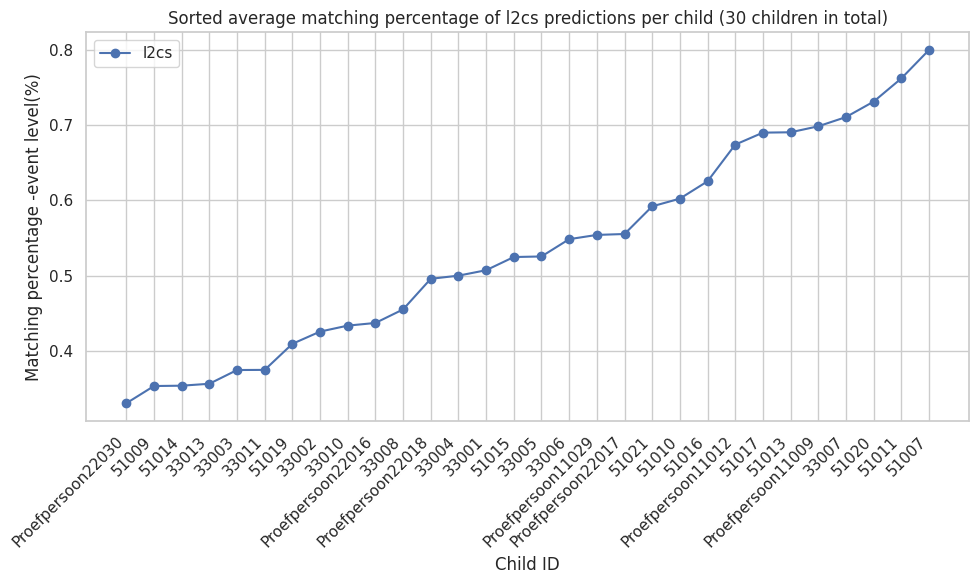

In [ ]:
plt.figure(figsize=(10,6))
x_labels = df_percentage_l2cs_sorted['child_id'].unique().tolist()
plt.plot(x_labels, df_percentage_l2cs_sorted['percentage'], label="l2cs", marker='o')
plt.xlabel("Child ID")
plt.ylabel("Matching percentage -event level(%)")
plt.title("Sorted average matching percentage of l2cs predictions per child (30 children in total)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Combine percentage plot with fixation time plot

In [ ]:
df_joint = df_fixation_sorted.merge(df_percentage_l2cs, on=['child_id'], how='left')

In [ ]:
# df_joint

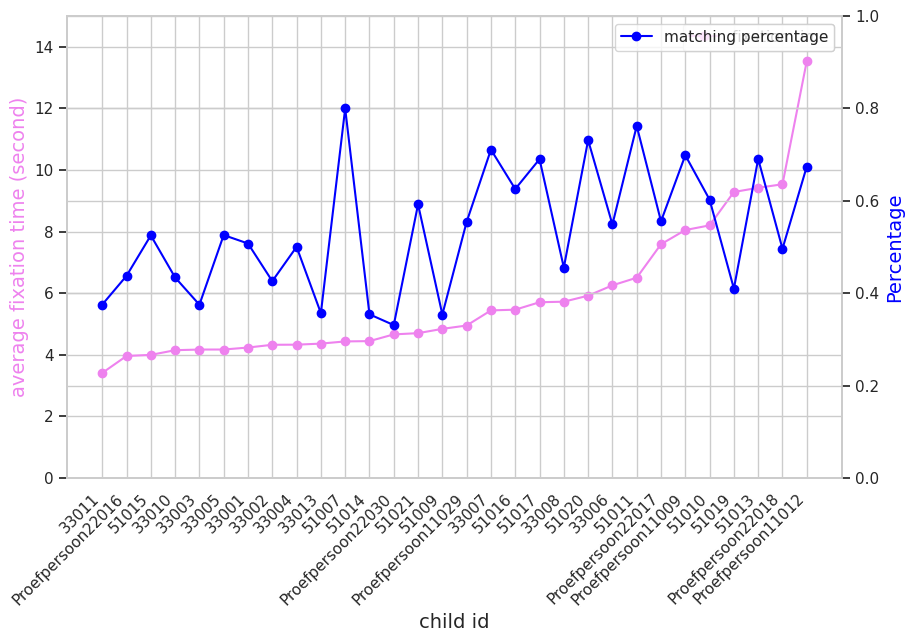

In [ ]:
# create figure and axis objects with subplots()
x_labels = df_fixation_sorted['child_id'].unique().tolist()
fig,ax = plt.subplots(figsize=(10,6))
# make a plot
ax.plot(x_labels, df_joint['avg_fixation_child'],
        color="violet", label="fixation time",
        marker="o")
# set x-axis label
ax.set_xlabel("child id", fontsize = 14)
# set y-axis label
ax.set_ylabel("average fixation time (second)",
              color="violet",
              fontsize=14)
ax.set_ylim(0,15)
plt.xticks(rotation=45, ha='right')
ax.legend()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x_labels, df_joint["percentage"],label="matching percentage",color="blue",marker="o")
ax2.set_ylabel("Percentage",color="blue",fontsize=14)
ax2.set_ylim(0,1)
plt.xticks(rotation=45, ha='right')
ax2.legend()
plt.show()

In [ ]:
# print(df_joint)

In [ ]:
print(df_joint['avg_fixation_child'].tolist())
print(df_joint['percentage'].tolist())

[3.408035746759151, 3.9595127189354695, 3.9947737556561087, 4.147219715956559, 4.168189247311828, 4.169220779220779, 4.233353868971221, 4.322811628833134, 4.326574712643677, 4.361026697177727, 4.4322109988776655, 4.44202380952381, 4.660512820512821, 4.700281101614435, 4.840014586014586, 4.948496287169056, 5.439334554334554, 5.4629665071770335, 5.703936507936508, 5.721846484165325, 5.917470552649372, 6.252777777777777, 6.500421865715983, 7.587614438394837, 8.048298232873396, 8.199952380952382, 9.283777777777779, 9.420277777777779, 9.53468253968254, 13.532169312169314]
[0.37513227513227515, 0.43740981240981247, 0.524906015037594, 0.433876357560568, 0.37494623655913983, 0.5256613756613756, 0.5074135342952547, 0.4259412431455442, 0.500191570881226, 0.3567124332570557, 0.799673202614379, 0.35415430686216337, 0.33082706766917286, 0.5921717171717171, 0.3537037037037037, 0.5542485245371492, 0.7106227106227107, 0.6253968253968254, 0.6899877899877901, 0.45539452495974236, 0.73114835770969, 0.548

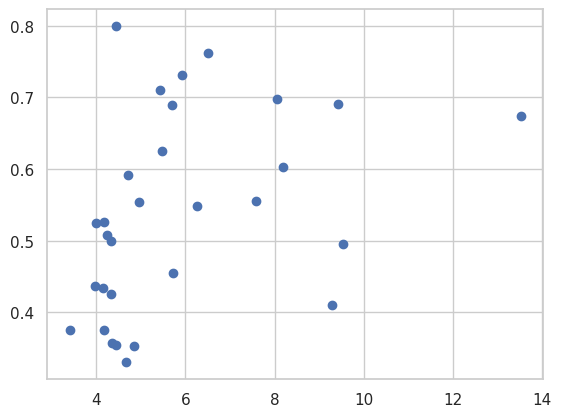

In [ ]:
plt.plot(df_joint['avg_fixation_child'], df_joint['percentage'], 'o')
plt.show()

# Event level (1, 3, 5s)

- df_vis_clean_no4
- df_invis_clean_no4


In [ ]:
df_measure_vis_event1 = pd.read_csv(root + 'results_analysis/different_event_level/event1/measure_vis.csv', header=0)
df_measure_invis_event1 = pd.read_csv(root + 'results_analysis/different_event_level/event1/measure_invis.csv', header=0)

df_measure_vis_event3 = pd.read_csv(root + 'results_analysis/different_event_level/event3/measure_vis.csv', header=0)
df_measure_invis_event3 = pd.read_csv(root + 'results_analysis/different_event_level/event3/measure_invis.csv', header=0)

df_measure_vis_event5 = pd.read_csv(root + 'results_analysis/different_event_level/event5/measure_vis.csv', header=0)
df_measure_invis_event5 = pd.read_csv(root + 'results_analysis/different_event_level/event5/measure_invis.csv', header=0)


In [ ]:
pct_vis_frame = pd.read_csv(root + 'results_analysis/frame_level/percentage_vis_raw_frame.csv')
pct_invis_frame = pd.read_csv(root + 'results_analysis/frame_level/percentage_invis_raw_frame.csv')

file_vis = pct_vis_frame['file'].tolist()
l2cs_vis = pct_vis_frame['Gaze_BB'].tolist()
base_vis = pct_vis_frame['Baseline'].tolist()
file_invis = pct_invis_frame['file'].tolist()
l2cs_invis = pct_invis_frame['Gaze_BB'].tolist()

df_measure_vis_event = pd.DataFrame(columns=['file', 'Gaze_BB', 'Baseline'])
df_measure_invis_event = pd.DataFrame(columns=['file', 'Gaze_BB'])

df_measure_vis_event['file'] = file_vis
df_measure_vis_event['Gaze_BB'] = l2cs_vis
df_measure_vis_event['Baseline'] = base_vis
df_measure_invis_event['file'] = file_invis
df_measure_invis_event['Gaze_BB'] = l2cs_invis

df_measure_vis_event.to_csv(root + 'results_analysis/frame_level/measure_vis_frame.csv')
df_measure_invis_event.to_csv(root + 'results_analysis/frame_level/measure_invis_frame.csv')

In [ ]:
df_measure_vis_event1.rename(columns = {'l2cs_pct':'Gaze_BB_vis', 'base_pct':'Baseline_vis'}, inplace = True)
df_measure_invis_event1.rename(columns = {'l2cs_pct':'Gaze_BB_invis'}, inplace = True)
df_measure_vis_event3.rename(columns = {'l2cs_pct':'Gaze_BB_vis', 'base_pct':'Baseline_vis'}, inplace = True)
df_measure_invis_event3.rename(columns = {'l2cs_pct':'Gaze_BB_invis'}, inplace = True)
df_measure_vis_event5.rename(columns = {'l2cs_pct':'Gaze_BB_vis', 'base_pct':'Baseline_vis'}, inplace = True)
df_measure_invis_event5.rename(columns = {'l2cs_pct':'Gaze_BB_invis'}, inplace = True)

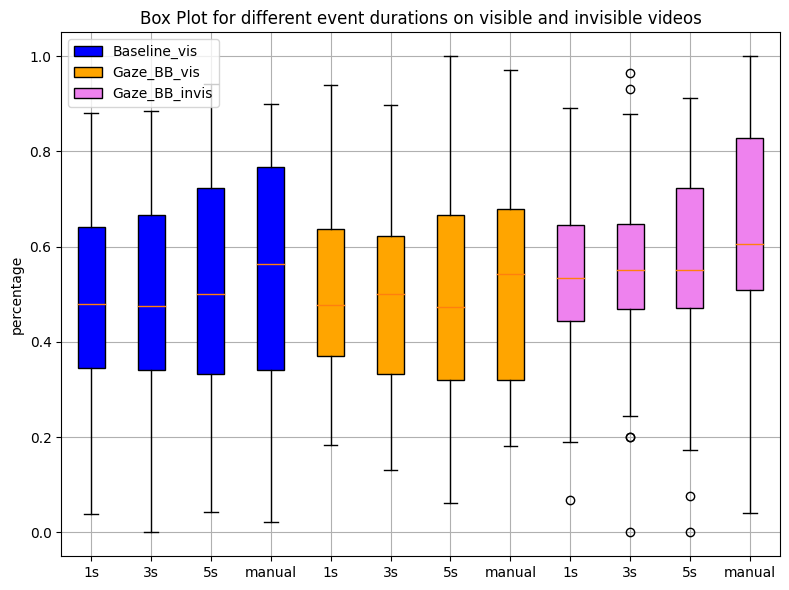

In [ ]:
# Draw the box plot
# plt.figure()
fig, ax = plt.subplots(figsize=(8, 6))
bp1 = ax.boxplot([df_measure_vis_event1['Baseline_vis'], df_measure_vis_event3['Baseline_vis'], df_measure_vis_event5['Baseline_vis'], df_measure_vis_event['Baseline']], vert=True, positions=[1, 2, 3, 4], labels=['1s', '3s', '5s', 'manual'], patch_artist=True, boxprops=dict(facecolor='blue'))
bp2 = ax.boxplot([df_measure_vis_event1['Gaze_BB_vis'], df_measure_vis_event3['Gaze_BB_vis'], df_measure_vis_event5['Gaze_BB_vis'], df_measure_vis_event['Gaze_BB']], vert=True, positions=[5, 6, 7, 8], labels=['1s', '3s', '5s', 'manual'], patch_artist=True, boxprops=dict(facecolor='orange'))
bp3 = ax.boxplot([df_measure_invis_event1['Gaze_BB_invis'], df_measure_invis_event3['Gaze_BB_invis'], df_measure_invis_event5['Gaze_BB_invis'], df_measure_invis_event['Gaze_BB']], vert=True, positions=[9, 10, 11, 12], labels=['1s', '3s', '5s', 'manual'], patch_artist=True, boxprops=dict(facecolor='violet'))

ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline_vis', 'Gaze_BB_vis', 'Gaze_BB_invis'])

# plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
plt.ylabel("percentage")
plt.title('Box Plot for different event durations on visible and invisible videos')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# df_vis_clean_no4

In [ ]:
# df_invis_clean_no4

In [ ]:
# df = pd.DataFrame({'A': [1,2,3,3,3,3,3,3,2,2], 'B': [2,2,2,1,1,1,2,2,3,3]})

for visible case (cleaned data)

In [ ]:
def mapping_to_event_level_with_seconds_vis(df, event_level=5):
  """
  Input:
  - df: dataframe that the class labels need to be mapped from frames to event level.
  - event_level: an int number that indicates the time duration, default is 5 according to the average fixation time per child.

  Output:
  - return a dataframe which the class labels are mapped to event level with the most frequent values in the event interval.
  """

  manual_list = []
  l2cs_list = []
  base_list = []
  file_list = []
  case_list = []
  df_temp = pd.DataFrame()

  vid_stats_file = '/content/drive/MyDrive/gaze_data/results/vidstat.csv'
  vid_stats = pd.read_csv(vid_stats_file, header=0, names=['file', 'frames', 'rate'])
  vid_stats_sorted = vid_stats.sort_values('file')

  for f in vid_stats_sorted['file'].unique():
    vid_single = vid_stats_sorted[vid_stats_sorted['file'] == f]
    frames = vid_single['frames'].iloc[0].astype(int)
    rate = vid_single['rate'].iloc[0].astype(int)

    # event_level = [rate * n for n in [1, 2, 3, 4, 5, 6, 7]]
    el = rate * event_level

    df_single = df[df['file'] == f]
    manual_class = df_single['class'].astype(int).copy()
    l2cs_class = df_single['m2prop_class'].astype(int).copy()
    base_class = df_single['base_class'].astype(int).copy()

    # for el in event_level:
    manual_event = manual_class.groupby(manual_class.index // el, group_keys=False).apply(lambda x: x.mode().iloc[0]).tolist()
    l2cs_event = l2cs_class.groupby(l2cs_class.index // el, group_keys=False).apply(lambda x: x.mode().iloc[0]).tolist()
    base_event = base_class.groupby(base_class.index // el, group_keys=False).apply(lambda x: x.mode().iloc[0]).tolist()

    file_list.extend([f] * len(manual_event))
    case_list.extend(['visible'] * len(manual_event))
    manual_list.extend(manual_event)
    l2cs_list.extend(l2cs_event)
    base_list.extend(base_event)

  df_temp['file'] = file_list
  df_temp['case'] = case_list
  df_temp['class'] = manual_list
  df_temp['l2cs'] = l2cs_list
  df_temp['base'] = base_list
  df_temp.to_csv(root + f'results_analysis/different_event_level/event{event_level}/df_vis_temp.csv')

  return df_temp

In [ ]:
def mapping_to_event_level_with_seconds_invis(df, event_level=5):
  """
  Input:
  - df: dataframe that the class labels need to be mapped from frames to event level.
  - event_level: an int number that indicates the time duration, default is 5 according to the average fixation time per child.

  Output:
  - return a dataframe which the class labels are mapped to event level with the most frequent values in the event interval.
  """

  manual_list = []
  l2cs_list = []
  file_list = []
  case_list = []
  df_temp = pd.DataFrame()

  vid_stats_file = '/content/drive/MyDrive/gaze_data/results/vidstat.csv'
  vid_stats = pd.read_csv(vid_stats_file, header=0, names=['file', 'frames', 'rate'])
  vid_stats_sorted = vid_stats.sort_values('file')

  for f in vid_stats_sorted['file'].unique():
    vid_single = vid_stats_sorted[vid_stats_sorted['file'] == f]
    frames = vid_single['frames'].iloc[0].astype(int)
    rate = vid_single['rate'].iloc[0].astype(int)

    # event_level = [rate * n for n in [1, 2, 3, 4, 5, 6, 7]]
    el = rate * event_level

    df_single = df[df['file'] == f]
    manual_class = df_single['class'].astype(int).copy()
    l2cs_class = df_single['m2prop_class'].astype(int).copy()

    # for el in event_level:
    manual_event = manual_class.groupby(manual_class.index // el, group_keys=False).apply(lambda x: x.mode().iloc[0]).tolist()
    l2cs_event = l2cs_class.groupby(l2cs_class.index // el, group_keys=False).apply(lambda x: x.mode().iloc[0]).tolist()

    file_list.extend([f] * len(manual_event))
    case_list.extend(['invisible'] * len(manual_event))
    manual_list.extend(manual_event)
    l2cs_list.extend(l2cs_event)

  df_temp['file'] = file_list
  df_temp['case'] = case_list
  df_temp['class'] = manual_list
  df_temp['l2cs'] = l2cs_list
  df_temp.to_csv(root + f'results_analysis/different_event_level/event{event_level}/df_invis_temp.csv')

  return df_temp

In [ ]:
def calculate_vis(df_vis_temp, event_level=5):
  # match_l2cs = []
  # match_base = []
  # krippen_l2cs = []
  # krippen_base = []

  df_measure_vis = pd.DataFrame(columns=['file', 'case', 'l2cs_pct', 'base_pct', 'l2cs_kappa', 'base_kappa', 'l2cs_krip', 'base_krip'])

  # df_percentage_vis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])
  # # df_percentage_invis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])
  # df_kappa_vis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])
  # # df_kappa_invis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])
  # df_krip_vis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])
  # # df_krip_invis = pd.DataFrame(columns=['file', 'case', 'l2cs', 'base'])

  for f in df_vis_temp['file'].unique():
    df_vis_temp_single = df_vis_temp[df_vis_temp['file'] == f]
    fcase = list(df_vis_temp_single['case'])[0]

    # calculate matching percentage
    match_base = (df_vis_temp_single["class"] == df_vis_temp_single["base"]).sum() / len(df_vis_temp_single["class"])
    match_l2cs = (df_vis_temp_single["class"] == df_vis_temp_single["l2cs"]).sum() / len(df_vis_temp_single["class"])

    # calculate cohen's kappa score
    manual = list(df_vis_temp_single['class'])
    l2cs = list(df_vis_temp_single['l2cs'])
    base = list(df_vis_temp_single['base'])
    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
    cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])

    # calculate krippendorff'a alpha score
    anns_manl2cs = []
    anns_manbase = []
    anns_manl2cs.append(manual)
    anns_manl2cs.append(l2cs)
    anns_manbase.append(manual)
    anns_manbase.append(base)
    krippen_l2cs = kd.alpha(anns_manl2cs, level_of_measurement='nominal')
    krippen_base = kd.alpha(anns_manbase, level_of_measurement='nominal')

    # fill columns into df_measure_vis where it stores results from three measurement methods
    df_measure_vis.loc[len(df_measure_vis)] = [f, fcase, match_l2cs, match_base, cohenk_l2cs, cohenk_base, krippen_l2cs, krippen_base]
    df_measure_vis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/measure_vis.csv')
  return df_measure_vis

In [ ]:
def calculate_invis(df_invis_temp, event_level=5):
  # match_l2cs = []
  # krippen_l2cs = []

  df_measure_invis = pd.DataFrame(columns=['file', 'case', 'l2cs_pct', 'l2cs_kappa', 'l2cs_krip'])

  for f in df_invis_temp['file'].unique():
    df_invis_temp_single = df_invis_temp[df_invis_temp['file'] == f]
    fcase = list(df_invis_temp_single['case'])[0]

    # calculate matching percentage
    match_l2cs = ((df_invis_temp_single["class"] == df_invis_temp_single["l2cs"]).sum() / len(df_invis_temp_single["class"]))

    # calculate cohen's kappa score
    manual = list(df_invis_temp_single['class'])
    l2cs = list(df_invis_temp_single['l2cs'])
    cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])

    # calculate krippendorff'a alpha score
    anns_manl2cs = []
    anns_manl2cs.append(manual)
    anns_manl2cs.append(l2cs)
    krippen_l2cs = (kd.alpha(anns_manl2cs, level_of_measurement='nominal'))

    # fill columns into df_measure_invis where it stores results from three measurement methods
    df_measure_invis.loc[len(df_measure_invis)] = [f, fcase, match_l2cs, cohenk_l2cs, krippen_l2cs]
    df_measure_invis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/measure_invis.csv')
  return df_measure_invis

In [ ]:
# def sns_plot_vis(df_measure, event_level=5):
#   df_percentage_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_pct', 'base_pct'],
#                                   var_name="method", value_name="Percentage")
#   df_kappa_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_kappa', 'base_kappa'],
#                                   var_name="method", value_name="Kappa")
#   df_krip_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_krip', 'base_krip'],
#                                   var_name="method", value_name="Krip")
#   # line plot for percentage
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Percentage", hue="method", data=df_percentage_vis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title(f"Matching Percentages in each visible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(0, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/percentage_vis_all.jpg')
#   plt.close()
#   print(f"x-axis for percentage: {df_percentage_vis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='l2cs_pct']['Pencentage'].tolist()}")
#   print(f"y-axis (base) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='base_pct']['Pencentage'].tolist()}")

#   # line plot for kappa
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_kappa_vis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Score")
#   plt.title(f"Cohen's kappa score for human-l2cs and human-baseline in each visible video (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 0.8)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/kappa_vis_all.jpg')
#   plt.colse()
#   print(f"x-axis for kappa: {df_kappa_vis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='l2cs_kappa']['Kappa'].tolist()}")
#   print(f"y-axis (base) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='base_kappa']['Kappa'].tolist()}")

#   # line plot for krip
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_vis)
#   plt.xlabel("File")
#   plt.ylabel("Krippendorff's Alpha Score")
#   plt.title(f"IRA (krip's alpha) in each visible video file (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/krip_vis_all.jpg')
#   plt.close()
#   print(f"x-axis for krip: {df_krip_vis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='l2cs_krip']['Krip'].tolist()}")
#   print(f"y-axis (base) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='base_krip']['Krip'].tolist()}")

#   return plt


In [ ]:
# def sns_plot_invis(df_measure, event_level=5):
#   df_percentage_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_pct'],
#                                   var_name="method", value_name="Percentage")
#   df_kappa_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_kappa'],
#                                   var_name="method", value_name="Kappa")
#   df_krip_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_krip'],
#                                   var_name="method", value_name="Krip")
#   # line plot for percentage
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Percentage", hue="method", data=df_percentage_invis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title(f"Matching Percentages in each invisible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(0, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/percentage_invis_all.jpg')
#   plt.close()
#   print(f"x-axis for percentage: {df_percentage_invis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for percentage: {df_percentage_invis_melt[df_percentage_invis_melt['method']=='l2cs_pct']['Pencentage'].tolist()}")

#   # line plot for kappa
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_kappa_invis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Score")
#   plt.title(f"Cohen's kappa score for human-l2cs in each invisible video (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 0.8)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/kappa_invis_all.jpg')
#   plt.colse()
#   print(f"x-axis for kappa: {df_kappa_invis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for kappa: {df_kappa_invis_melt[df_kappa_invis_melt['method']=='l2cs_kappa']['Kappa'].tolist()}")

#   # line plot for krip
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_invis)
#   plt.xlabel("File")
#   plt.ylabel("Krippendorff's Alpha Score")
#   plt.title(f"IRA (krip's alpha) in each invisible video file (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show(block=False)
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/krip_invis_all.jpg')
#   plt.close()
#   print(f"x-axis for krip: {df_krip_invis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for krip: {df_krip_invis_melt[df_krip_invis_melt['method']=='l2cs_krip']['Krip'].tolist()}")

#   return plt


In [ ]:
# def line_plot_vis(df_measure, event_level=5):
#   # line plot for percentage
#   ['file', 'case', 'l2cs_pct', 'base_pct', 'l2cs_kappa', 'base_kappa', 'l2cs_krip', 'base_krip'])
#   plt.figure(figsize=(10,6))
#   x_labels = df_measure['file'].unique().tolist()
#   plt.plot(x_labels, df_measure['l2cs_pct'], label="l2cs", marker='o')
#   plt.plot(x_labels, df_measure['base_pct'], label="base", marker='o')
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title("Matching Percentages in each visible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.legend()
#   plt.tight_layout()
#   # plt.show()
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/percentage_vis_all.jpg')
#   plt.close()
#   print(f"x-axis for percentage: {df_percentage_vis_melt['file'].unique().tolist()}")
#   print(f"y-axis (l2cs) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='l2cs_pct']['Pencentage'].tolist()}")
#   print(f"y-axis (base) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='base_pct']['Pencentage'].tolist()}")

#   # line plot for kappa
#   plt.figure(figsize=(10,6))
#   x_labels = df_measure['file'].unique().tolist()
#   plt.plot(x_labels, df_measure['l2cs_pct'], label="l2cs", marker='o')
#   plt.plot(x_labels, df_measure['base_pct'], label="base", marker='o')
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title("Matching Percentages in each visible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.legend()
#   plt.tight_layout()
#   # plt.show()
#   plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/percentage_vis_all.jpg')
#   plt.close()

In [ ]:
def sns_plot_vis_all3(df_measure, event_level=5):
  df_percentage_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_pct', 'base_pct'],
                                  var_name="method", value_name="Value")
  df_kappa_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_kappa', 'base_kappa'],
                                  var_name="method", value_name="Value")
  df_krip_vis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_krip', 'base_krip'],
                                  var_name="method", value_name="Value")
  # line plot for percentage
  sns.set(style="whitegrid")
  # plt.figure(figsize=(10, 8))
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.lineplot(x="file", y="Value", hue="method", data=df_percentage_vis_melt, ax=ax, palette=['red', 'blue'])
  sns.lineplot(x="file", y="Value", hue="method", data=df_kappa_vis_melt, ax=ax, palette=['purple', 'pink'])
  sns.lineplot(x="file", y="Value", hue="method", data=df_krip_vis_melt, ax=ax, palette=['yellow', 'green'])
  plt.xlabel("File")
  plt.ylabel("Value")
  plt.title(f"Scores from 3 measures on each visible video file (event - {event_level}s)")
  plt.xticks(rotation=75, ha='right')
  # plt.ylim(0, 1)  # Set the y-axis limits
  plt.tight_layout()
  # plt.show(block=False)
  plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/plot_3measures_vis_all.jpg')
  plt.close()

  print(f"x-axis for percentage: {df_percentage_vis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='l2cs_pct']['Value'].tolist()}")
  print(f"y-axis (base) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='base_pct']['Value'].tolist()}")
  print()
  print(f"x-axis for kappa: {df_kappa_vis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='l2cs_kappa']['Value'].tolist()}")
  print(f"y-axis (base) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='base_kappa']['Value'].tolist()}")
  print()
  print(f"x-axis for krip: {df_krip_vis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='l2cs_krip']['Value'].tolist()}")
  print(f"y-axis (base) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='base_krip']['Value'].tolist()}")

  with open(root + f'results_analysis/different_event_level/event{event_level}/vis_plot_info.txt', 'a+') as file:
    file.write(f"x-axis for percentage: {df_percentage_vis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='l2cs_pct']['Value'].tolist()}")
    file.write('\n')
    file.write(f"y-axis (base) for percentage: {df_percentage_vis_melt[df_percentage_vis_melt['method']=='base_pct']['Value'].tolist()}")
    file.write('\n')
    file.write(f"x-axis for kappa: {df_kappa_vis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='l2cs_kappa']['Value'].tolist()}")
    file.write('\n')
    file.write(f"y-axis (base) for kappa: {df_kappa_vis_melt[df_kappa_vis_melt['method']=='base_kappa']['Value'].tolist()}")
    file.write('\n')
    file.write(f"x-axis for krip: {df_krip_vis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='l2cs_krip']['Value'].tolist()}")
    file.write('\n')
    file.write(f"y-axis (base) for krip: {df_krip_vis_melt[df_krip_vis_melt['method']=='base_krip']['Value'].tolist()}")

  return plt


In [ ]:
def sns_plot_invis_all3(df_measure, event_level=5):
  df_percentage_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_pct'],
                                  var_name="method", value_name="Value")
  df_kappa_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_kappa'],
                                  var_name="method", value_name="Value")
  df_krip_invis_melt = df_measure.melt(id_vars=["file"], value_vars=['l2cs_krip'],
                                  var_name="method", value_name="Value")
  # line plot for percentage
  sns.set(style="whitegrid")
  # plt.figure(figsize=(10, 8))
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.lineplot(x="file", y="Value", hue="method", data=df_percentage_invis_melt, ax=ax, palette=['blue'])
  sns.lineplot(x="file", y="Value", hue="method", data=df_kappa_invis_melt, ax=ax, palette=['purple'])
  sns.lineplot(x="file", y="Value", hue="method", data=df_krip_invis_melt, ax=ax, palette=['green'])
  plt.xlabel("File")
  plt.ylabel("Value")
  plt.title(f"Scores from 3 measures on each invisible video file (event - {event_level}s)")
  plt.xticks(rotation=75, ha='right')
  # plt.ylim(0, 1)  # Set the y-axis limits
  plt.tight_layout()
  # plt.show(block=False)
  plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/plot_3measures_invis_all.jpg')
  plt.close()
  print(f"x-axis for percentage: {df_percentage_invis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for percentage: {df_percentage_invis_melt[df_percentage_invis_melt['method']=='l2cs_pct']['Value'].tolist()}")
  print()
  print(f"x-axis for kappa: {df_kappa_invis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for kappa: {df_kappa_invis_melt[df_kappa_invis_melt['method']=='l2cs_kappa']['Value'].tolist()}")
  print()
  print(f"x-axis for krip: {df_krip_invis_melt['file'].unique().tolist()}")
  print(f"y-axis (l2cs) for krip: {df_krip_invis_melt[df_krip_invis_melt['method']=='l2cs_krip']['Value'].tolist()}")

  with open(root + f'results_analysis/different_event_level/event{event_level}/invis_plot_info.txt', 'a+') as file:
    file.write(f"x-axis for percentage: {df_percentage_invis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for percentage: {df_percentage_invis_melt[df_percentage_invis_melt['method']=='l2cs_pct']['Value'].tolist()}")
    file.write('\n')
    file.write(f"x-axis for kappa: {df_kappa_invis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for kappa: {df_kappa_invis_melt[df_kappa_invis_melt['method']=='l2cs_kappa']['Value'].tolist()}")
    file.write('\n')
    file.write(f"x-axis for krip: {df_krip_invis_melt['file'].unique().tolist()}")
    file.write('\n')
    file.write(f"y-axis (l2cs) for krip: {df_krip_invis_melt[df_krip_invis_melt['method']=='l2cs_krip']['Value'].tolist()}")

  return plt


percentage (visible videos)

In [ ]:
# def calculate_percentage_vis(df_vis_temp, event_level=5):
#   match_l2cs_vis = []
#   match_base = []
#   df_percentage_vis = pd.DataFrame()
#   for f in df_vis_temp['file'].unique():
#     df_vis_temp_single = df_vis_temp[df_vis_temp['file'] == f]
#     match_base.append((df_vis_temp_single["class"] == df_vis_temp_single["base"]).sum() / len(df_vis_temp_single["class"]))
#     match_l2cs_vis.append((df_vis_temp_single["class"] == df_vis_temp_single["l2cs"]).sum() / len(df_vis_temp_single["class"]))

#   df_percentage_vis['file'] = df_vis_temp['file'].unique().tolist()
#   df_percentage_vis['case'] = ['visible'] * len(df_percentage_vis['file'])
#   df_percentage_vis['l2cs'] = match_l2cs_vis
#   df_percentage_vis['base'] = match_base
#   df_percentage_vis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/percentage_vis_raw{event_level}.csv')

#   return df_percentage_vis

In [ ]:
# def sns_plot_vis(df_percentage_vis, event_level=5)
#   df_percentage_vis_melt = df_percentage_vis.melt(id_vars=["file"], value_vars=["l2cs", "base"],
#                                   var_name="method", value_name="Percentage")

#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Percentage", hue="method", data=df_percentage_vis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title(f"Matching Percentages in each visible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(0, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   plt.show()
#   return plt

percentage (invisible videos)

In [ ]:
# def calculate_percentage_invis(df_invis_temp, event_level=5):
#   match_l2cs_invis = []
#   df_percentage_invis = pd.DataFrame()
#   for f in df_invis_temp['file'].unique():
#     df_invis_temp_single = df_invis_temp[df_invis_temp['file'] == f]
#     match_l2cs_invis.append((df_invis_temp_single["class"] == df_invis_temp_single["l2cs"]).sum() / len(df_invis_temp_single["class"]))

#   df_percentage_invis['file'] = df_invis_temp['file'].unique().tolist()
#   df_percentage_invis['case'] = ['invisible'] * len(df_percentage_invis['file'])
#   df_percentage_invis['l2cs'] = match_l2cs_invis
#   df_percentage_invis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/percentage_invis_raw{event_level}.csv')

#   return df_percentage_invis

In [ ]:
# def sns_plot_percentage_invis(df_percentage_invis, event_level=5)
#   df_percentage_invis_melt = df_percentage_invis.melt(id_vars=["file"], value_vars=["l2cs"],
#                                   var_name="method", value_name="Percentage")

#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Percentage", hue="method", data=df_percentage_invis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Percentage")
#   plt.title(f"Matching Percentages in each invisible video file (event - {event_level}s)")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(0, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   plt.show()
#   return plt

kappa score (visible videos)

In [ ]:
# def calculate_kappa_vis(df_vis_temp, event_level=5):
#   dfkappa_vis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manbase'])
#   for f in df_vis['file'].unique():
#     fcase = list(df_vis[df_vis['file'] == f]['case'])[0]
#     manual = list(df_vis[df_vis['file'] == f]['class'])
#     l2cs = list(df_vis[df_vis['file'] == f]['l2cs'])
#     base = list(df_vis[df_vis['file'] == f]['base'])

#     cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
#     cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
#     dfkappa_vis_no4.loc[len(dfkappa_vis_no4)] = [f, fcase, cohenk_l2cs, cohenk_base]

#   dfkappa_vis_no4.to_csv(root + f'results_analysis/different_event_level/event{event_level}/ckappa_vis_event{event_level}.csv')
#   return dfkappa_vis_no4

In [ ]:
# def sns_vis_kappa_plot(dfkappa_vis, event_level=5):
#   # line plot for visible case
#   df_kappa_vis_melt = dfkappa_vis.melt(id_vars=["file"], value_vars=["ckappa_manl2cs", "ckappa_manbase"],
#                                  var_name="measure type", value_name="Score")
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_vis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Score")
#   plt.title(f"Cohen's kappa score for human-l2cs and human-baseline in each visible video (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 0.8)  # Set the y-axis limits
#   plt.tight_layout()
#   plt.show()
#   return plt

kappa (invisible videos)

In [ ]:
# def calculate_kappa_invis(df_invis_temp, event_level=5):
#   dfkappa_invis_no4 = pd.DataFrame(columns=['file', 'case', 'ckappa_manl2cs', 'ckappa_manbase'])
#   for f in df_invis['file'].unique():
#     fcase = list(df_invis[df_invis['file'] == f]['case'])[0]
#     manual = list(df_invis[df_invis['file'] == f]['class'])
#     l2cs = list(df_invis[df_invis['file'] == f]['l2cs'])

#     cohenk_l2cs = cohen_kappa_score(manual, l2cs, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
#     cohenk_base = cohen_kappa_score(manual, base, labels=[TABLE, ROBOT, TABLET, ELSEWHERE])
#     dfkappa_vis_no4.loc[len(dfkappa_vis_no4)] = [f, fcase, cohenk_l2cs, cohenk_base]

#   dfkappa_vis_no4.to_csv(root + f'results_analysis/different_event_level/event{event_level}/ckappa_vis_event{event_level}.csv')
#   return dfkappa_vis_no4

In [ ]:
# def sns_invis_kappa_plot(dfkappa_invis, event_level=5):
#   # line plot for visible case
#   df_kappa_invis_melt = dfkappa_invis.melt(id_vars=["file"], value_vars=["ckappa_manl2cs"],
#                                  var_name="measure type", value_name="Score")
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="measure type", data=df_kappa_vis_melt)
#   plt.xlabel("File")
#   plt.ylabel("Score")
#   plt.title(f"Cohen's kappa score for human-l2cs and human-baseline in each invisible video (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 0.8)  # Set the y-axis limits
#   plt.tight_layout()
#   plt.show()
#   return plt

Krippendorff's alpha score (visible videos)

In [ ]:
# def calculate_krip_vis(df_vis_temp, event_level=5):
#   krippen_l2cs_vis = []
#   krippen_base = []
#   df_krip_vis = pd.DataFrame()

#   for f in df_vis_temp['file'].unique():
#     anns_manl2cs = []
#     anns_manbase = []
#     manual = list(df_vis_temp[df_vis_temp['file'] == f]['class'])
#     l2cs = list(df_vis_temp[df_vis_temp['file'] == f]['l2cs'])
#     base = list(df_vis_temp[df_vis_temp['file'] == f]['base'])

#     anns_manl2cs.append(manual)
#     anns_manl2cs.append(l2cs)
#     anns_manbase.append(manual)
#     anns_manbase.append(base)

#     krippen_l2cs_vis.append(kd.alpha(anns_manl2cs, level_of_measurement='nominal'))
#     krippen_base.append(kd.alpha(anns_manbase, level_of_measurement='nominal'))
#     df_krip_vis['file'] = df_vis_temp['file'].unique().tolist()
#     df_krip_vis['case'] = ['visible'] * len(df_krip_vis['file'])
#     df_krip_vis['l2cs'] = krippen_l2cs_vis
#     df_krip_vis['base'] = krippen_base
#     df_krip_vis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/krip_vis_event{event_level}.csv')
#   return df_krip_vis

In [ ]:
# def sns_krip_vis_plot(df_krip_vis, event_level=5):
#   df_krip_melt_vis = df_krip_vis.melt(id_vars=["file"], value_vars=["l2cs", "base"],
#                                  var_name="method", value_name="Score")
#   # line plot for visible case
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_vis)
#   plt.xlabel("File")
#   plt.ylabel("Krippendorff's Alpha Score")
#   plt.title(f"IRA (krip's alpha) in each visible video file (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   plt.show()
#   return plt

krip score (invisible videos)

In [ ]:
# def calculate_krip_invis(df_invis_temp, event_level=5):
#   krippen_l2cs_invis = []
#   df_krip_invis = pd.DataFrame()

#   for f in df_invis_temp['file'].unique():
#     anns_manl2cs = []
#     manual = list(df_invis_temp[df_invis_temp['file'] == f]['class'])
#     l2cs = list(df_invis_temp[df_invis_temp['file'] == f]['l2cs'])

#     anns_manl2cs.append(manual)
#     anns_manl2cs.append(l2cs)

#     krippen_l2cs_invis.append(kd.alpha(anns_manl2cs, level_of_measurement='nominal'))
#     df_krip_invis['file'] = df_invis_temp['file'].unique().tolist()
#     df_krip_invis['case'] = ['invisible'] * len(df_krip_invis['file'])
#     df_krip_invis['l2cs'] = krippen_l2cs_invis
#     df_krip_invis.to_csv(root + f'results_analysis/different_event_level/event{event_level}/krip_invis_event{event_level}.csv')
#   return df_krip_invis

In [ ]:
# def sns_krip_invis_plot(df_krip_invis, event_level=5):
#   df_krip_melt_invis = df_krip_invis.melt(id_vars=["file"], value_vars=["l2cs"],
#                                  var_name="method", value_name="Score")
#   # line plot for visible case
#   sns.set(style="whitegrid")
#   plt.figure(figsize=(10, 6))
#   sns.lineplot(x="file", y="Score", hue="method", data=df_krip_melt_invis)
#   plt.xlabel("File")
#   plt.ylabel("Krippendorff's Alpha Score")
#   plt.title(f"IRA (krip's alpha) in each invisible video file (event-{event_level})")
#   plt.xticks(rotation=75, ha='right')
#   plt.ylim(-0.5, 1)  # Set the y-axis limits
#   plt.tight_layout()
#   # plt.show()
#   print(f"x and y axis for krip invis line plot:")
#   print(f"x-axis: {df_krip_invis['file']}")
#   print(f"y-axis: {df_krip_invis['l2cs']}")
#   return plt

three measures on all videos (percentage, kappa, krip)

In [ ]:
# def box_plot_3measures(df_percentage_vis, df_kappa_vis, df_krip_vis, df_percentage_invis, df_kappa_invis, df_krip_invis, event_level=5):
#   # Draw the box plot for both DataFrames in one plot
#   fig, ax = plt.subplots(figsize=(10, 6))
#   bp1 = ax.boxplot([df_percentage_vis['l2cs_m2p'], df_percentage_vis['baseline'], df_percentage_invis['l2cs_m2prop']], vert=True, positions=[1, 2, 3], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='blue'))
#   bp2 = ax.boxplot([df_kappa_vis['ckappa_manl2cs'], df_kappa_vis['ckappa_manbase'], df_kappa_invis['ckappa_manl2cs']], vert=True, positions=[4, 5, 6], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))
#   bp3 = ax.boxplot([df_krip_vis['krip_manl2cs'], df_krip_vis['krip_manbase'], df_krip_invis['krip_manl2csm2p']], vert=True, positions=[7, 8, 9], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='violet'))

#   ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["Percentage", "Cohen's Kappa", "Krippendorff's Alpha"])

#   plt.title('Box Plot for three different measures on visible and invisible cases')
#   # plt.show()
#   print(f"x and y axis for 3-measures box plot:")
#   print(f"x-axis: {df_krip_invis['file']}")
#   print(f"y-axis: {df_krip_invis['l2cs']}")
#   return plt

In [ ]:
def box_plot_3measures(df_measure_vis, df_measure_invis, event_level=5):
  # Draw the box plot for both DataFrames in one plot
  fig, ax = plt.subplots(figsize=(10, 6))
  bp1 = ax.boxplot([df_measure_vis['l2cs_pct'], df_measure_vis['base_pct'], df_measure_invis['l2cs_pct']], vert=True, positions=[1, 2, 3], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='blue'))
  bp2 = ax.boxplot([df_measure_vis['l2cs_kappa'], df_measure_vis['base_kappa'], df_measure_invis['l2cs_kappa']], vert=True, positions=[4, 5, 6], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='orange'))
  bp3 = ax.boxplot([df_measure_vis['l2cs_krip'], df_measure_vis['base_krip'], df_measure_invis['l2cs_krip']], vert=True, positions=[7, 8, 9], labels=['l2cs_vis', 'baseline_vis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='violet'))

  ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["Percentage", "Cohen's Kappa", "Krippendorff's Alpha"])

  plt.title('Box Plot for three different measures on visible and invisible cases')
  plt.tight_layout()
  # plt.show(block=False)
  plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/boxplot_3measures_all.jpg')
  plt.close()
  # print(f"x and y axis for 3-measures box plot:")
  # print(f"x-axis: {df_krip_invis['file']}")
  # print(f"y-axis: {df_krip_invis['l2cs']}")
  return plt


In [ ]:
def box_plot_3measures_option(df_measure_vis, df_measure_invis, event_level=5):
  # Draw the box plot for both DataFrames in one plot
  # plt.figure()
  fig, ax = plt.subplots(figsize=(10, 6))
  bp1 = ax.boxplot([df_measure_vis['base_pct'], df_measure_vis['base_kappa'], df_measure_vis['base_krip']], vert=True, positions=[1, 4, 7], labels=['baseline_vis', 'baseline_vis', 'baseline_vis'], patch_artist=True, boxprops=dict(facecolor='blue'))
  bp2 = ax.boxplot([df_measure_vis['l2cs_pct'], df_measure_vis['l2cs_kappa'], df_measure_vis['l2cs_krip']], vert=True, positions=[2, 5, 8], labels=['l2cs_vis', 'l2cs_vis', 'l2cs_vis'], patch_artist=True, boxprops=dict(facecolor='orange'))
  bp3 = ax.boxplot([df_measure_invis['l2cs_pct'], df_measure_invis['l2cs_kappa'], df_measure_invis['l2cs_krip'],], vert=True, positions=[3, 6, 9], labels=['l2cs_invis', 'l2cs_invis', 'l2cs_invis'], patch_artist=True, boxprops=dict(facecolor='violet'))

  ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Baseline', 'L2CS-visible', 'L2CS-invisible'])

  plt.xlabel("Percentage                Cohen's Kappa               Krippendorff's Alpha")
  plt.ylabel("Value")
  plt.title('Box Plot for three different measures on visible and invisible cases')
  plt.tight_layout()
  # plt.show(block=False)
  plt.savefig(root + f'results_analysis/different_event_level/event{event_level}/boxplot_3measures_all_option.jpg')
  plt.close()
  # plt.show()
  # print(f"x and y axis for 3-measures box plot:")
  # print(f"x-axis: {df_krip_invis['file']}")
  # print(f"y-axis: {df_krip_invis['l2cs']}")
  return plt


In [ ]:
# event_level = [1, 2, 3, 4, 5, 6, 7]
for evt in event_level:
  df_vis_temp = mapping_to_event_level_with_seconds_vis(df_vis_clean_no4, event_level=evt)
  df_invis_temp = mapping_to_event_level_with_seconds_invis(df_invis_clean_no4, event_level=evt)

  df_measure_vis = calculate_vis(df_vis_temp, event_level=evt)
  df_measure_invis = calculate_invis(df_invis_temp, event_level=evt)

  sns_plot_vis_all3(df_measure_vis, event_level=evt)
  sns_plot_invis_all3(df_measure_invis, event_level=evt)
  box_plot_3measures(df_measure_vis, df_measure_invis, event_level=evt)
  box_plot_3measures_option(df_measure_vis, df_measure_invis, event_level=evt)

x-axis for percentage: ['33001_sessie1_taskrobotEngagement', '33001_sessie2_taskrobotEngagement', '33001_sessie3_taskrobotEngagement', '33002_sessie1_taskrobotEngagement', '33002_sessie2_taskrobotEngagement', '33002_sessie3_taskrobotEngagement', '33003_sessie1_taskrobotEngagement', '33003_sessie3_robotEngagement1', '33003_sessie3_taskrobotEngagement', '33004_sessie1_taskrobotEngagement', '33004_sessie2_taskrobotEngagement', '33004_sessie3_taskrobotEngagement', '33005_sessie1_taskrobotEngagement', '33005_sessie2_taskrobotEngagement', '33005_sessie3_taskrobotEngagement', '33006_sessie1_taskrobotEngagement', '33006_sessie2_taskrobotEngagement', '33006_sessie3_taskrobotEngagement', '33007_sessie1_taskrobotEngagement', '33007_sessie2_taskrobotEngagement', '33007_sessie3_taskrobotEngagement', '33008_sessie1_taskrobotEngagement', '33008_sessie2_taskrobotEngagement', '33008_sessie3_taskrobotEngagement', '33010_sessie1_taskrobotEngagement', '33010_sessie2_taskrobotEngagement', '33010_sessie3_ta

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


ValueError: ignored

In [ ]:
event_level = [7]
for evt in event_level:
  df_vis_temp = mapping_to_event_level_with_seconds_vis(df_vis_clean_no4, event_level=evt)
  df_invis_temp = mapping_to_event_level_with_seconds_invis(df_invis_clean_no4, event_level=evt)

  df_measure_vis = calculate_vis(df_vis_temp, event_level=evt)
  df_measure_invis = calculate_invis(df_invis_temp, event_level=evt)

  sns_plot_vis_all3(df_measure_vis, event_level=evt)
  sns_plot_invis_all3(df_measure_invis, event_level=evt)
  box_plot_3measures(df_measure_vis, df_measure_invis, event_level=evt)
  box_plot_3measures_option(df_measure_vis, df_measure_invis, event_level=evt)

KeyboardInterrupt: ignored

In [ ]:
# evt = 3
# df_vis_temp = mapping_to_event_level_with_seconds_vis(df_vis_clean_no4, event_level=evt)
# # df_invis_temp = mapping_to_event_level_with_seconds_invis(df_invis_clean_no4, event_level=evt)

# df_measure_vis = calculate_vis(df_vis_temp, event_level=evt)
# # df_measure_invis = calculate_invis(df_invis_temp, event_level=evt)
# sns_plot_vis_all3(df_measure_vis, event_level=evt)
# # df_measure_vis

# # sns_plot_vis(df_measure_vis, event_level=evt)
# # sns_plot_invis(df_measure_invis, event_level=evt)

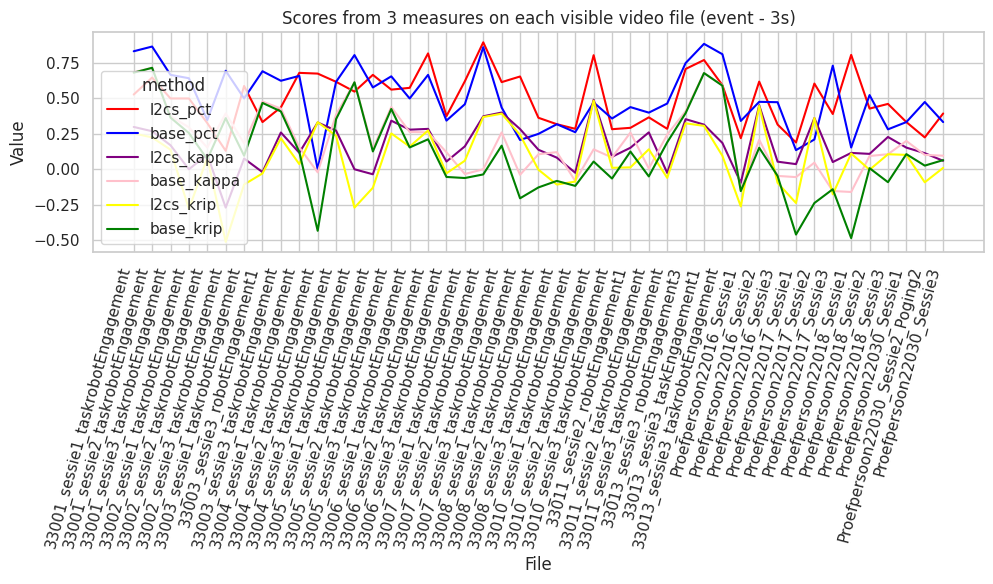

x-axis for percentage: ['33001_sessie1_taskrobotEngagement', '33001_sessie2_taskrobotEngagement', '33001_sessie3_taskrobotEngagement', '33002_sessie1_taskrobotEngagement', '33002_sessie2_taskrobotEngagement', '33002_sessie3_taskrobotEngagement', '33003_sessie1_taskrobotEngagement', '33003_sessie3_robotEngagement1', '33003_sessie3_taskrobotEngagement', '33004_sessie1_taskrobotEngagement', '33004_sessie2_taskrobotEngagement', '33004_sessie3_taskrobotEngagement', '33005_sessie1_taskrobotEngagement', '33005_sessie2_taskrobotEngagement', '33005_sessie3_taskrobotEngagement', '33006_sessie1_taskrobotEngagement', '33006_sessie2_taskrobotEngagement', '33006_sessie3_taskrobotEngagement', '33007_sessie1_taskrobotEngagement', '33007_sessie2_taskrobotEngagement', '33007_sessie3_taskrobotEngagement', '33008_sessie1_taskrobotEngagement', '33008_sessie2_taskrobotEngagement', '33008_sessie3_taskrobotEngagement', '33010_sessie1_taskrobotEngagement', '33010_sessie2_taskrobotEngagement', '33010_sessie3_ta

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# sns_plot_vis_all3(df_measure_vis, event_level=evt)

# New Section

In [ ]:
# # Calculate the number of groups with three videos
# num_child = len(pct_all_sorted) // 3

# # Reshape the DataFrame into groups of three videos each
# groups = [pct_all_sorted.iloc[i * 3: (i + 1) * 3] for i in range(num_child)]

# # Calculate the average for each group
# averages_pct = [group["l2cs_m2p"].mean() for group in groups]

# # If there are remaining values, calculate the average for the last group
# if len(pct_all_sorted) % 3 != 0:
#     last_group = pct_all_sorted.iloc[-(len(pct_all_sorted) % 3):]
#     averages_pct.append(last_group["l2cs_m2p"].mean())

In [ ]:
# df_aggr = pd.DataFrame(['Criteria', 'Baseline_vis', 'Gaze_BB_vis', 'Gaze_BB_invis', 'event_Baseline_vis', 'event_Gaze_BB_vis', 'event_Gaze_BB_invis'])
df_aggr = pd.DataFrame()
df_aggr['Criteria'] = ['Most', '50%', '60%', '70%', '80%']
df_aggr['Baseline_vis'] = [54, 54, 57, 59, 59]
df_aggr['Gaze_BB_vis'] = [52, 55, 59, 67, 72]
df_aggr['Gaze_BB_invis'] = [63, 68, 71, 75, 77]
df_aggr['event_Baseline_vis'] = [100, 93, 83, 68, 55]
df_aggr['event_Gaze_BB_vis'] = [100, 86, 69, 54, 40]
df_aggr['event_Gaze_BB_invis'] = [100, 83, 66, 50, 35]

In [ ]:
df_aggr

Criteria  Baseline_vis  Gaze_BB_vis  Gaze_BB_invis  event_Baseline_vis  \
0     Most            54           52             63                 100   
1      50%            54           55             68                  93   
2      60%            57           59             71                  83   
3      70%            59           67             75                  68   
4      80%            59           72             77                  55   

   event_Gaze_BB_vis  event_Gaze_BB_invis  
0                100                  100  
1                 86                   83  
2                 69                   66  
3                 54                   50  
4                 40                   35

In [ ]:

df_aggr_melt = df_aggr.melt(id_vars=["Criteria"], value_vars=['Baseline_vis', 'Gaze_BB_vis', 'Gaze_BB_invis', 'event_Baseline_vis', 'event_Gaze_BB_vis', 'event_Gaze_BB_invis'],
                                 var_name="method & data points", value_name="Percentage")

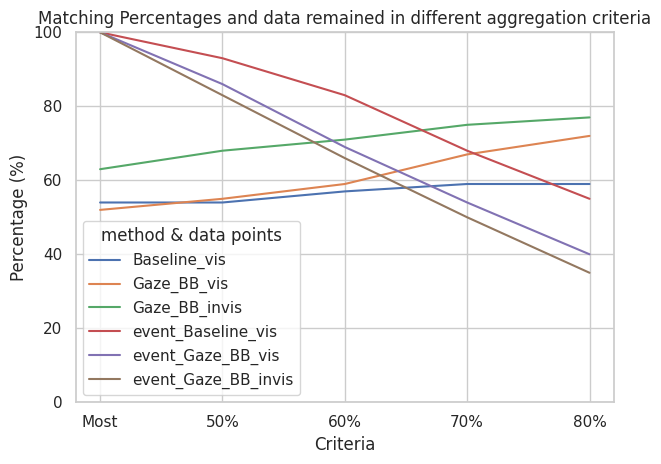

In [ ]:
# line plot for visible case
sns.set(style="whitegrid")
plt.figure()
sns.lineplot(x="Criteria", y="Percentage", hue="method & data points", data=df_aggr_melt)
plt.xlabel("Criteria")
plt.ylabel("Percentage (%)")
plt.title("Matching Percentages and data remained in different aggregation criteria")
# plt.xticks(rotation=75, ha='right')
plt.ylim(0, 100)  # Set the y-axis limits
plt.tight_layout()
plt.show()